# 社群媒體分析期中專案-第11組
## 專案主題：台中顏家中二選區在地勢力

成員：朱淓璘 M104020018、蕭清耀	M104020038、邱承漢 M104020029、王培碩	M104020011


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##動機與分析目的
近期，台中第二選區立委即將補選，然而，立委參選人之一顏寬恒的家族風波不斷，許多人在討論及爆料。因此，以「台中顏家」作為分析的主題。

分析方向:
1. 各情緒的字詞分佈有甚麼不同，代表字詞有哪些?
2. 透過TF-IDF找出文章以及字詞間的關聯。
3. 此資料集用什麼樣的模型預測，準確率會較高？

##基本資料介紹
- 資料來源: 文字平台收集PTT Gossip版2021-10-23 ~ 2021-11-25 所有文章
- 資料集： `raw_data/顏寬恒_articleMetaData.csv`、`raw_data/顏寬恒_articleReviews.csv`
- 關鍵字：顏寬恒、顏清標、顏清山、海線黑道、顏家
- 資料時間：2021-10-23 ~ 2021-11-25

In [ ]:
# 確認當前目錄
%cd /content/drive/MyDrive/研究所/碩一上/社群媒體分析/期中專案/
%pwd

/content/drive/MyDrive/研究所/碩一上/社群媒體分析/期中專案


'/content/drive/MyDrive/研究所/碩一上/社群媒體分析/期中專案'

In [ ]:
import pandas as pd
import re
import time
import string
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import math
import jieba
import matplotlib.font_manager
import nltk
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn import metrics, model_selection, feature_extraction
from sklearn import feature_extraction, model_selection, naive_bayes,pipeline,\
manifold, preprocessing, feature_selection, metrics, svm, tree, ensemble
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from wordcloud import WordCloud
from datetime import datetime 

In [ ]:
matplotlib.font_manager.fontManager.addfont('./SourceHanSansTW-Regular.otf')
matplotlib.rc('font', family='Source Han Sans TW')

In [ ]:
plt.rcParams['font.sans-serif'] = ['Source Han Sans TW']
plt.rcParams['axes.unicode_minus']=False #使負號能夠顯示

## 文字前處理

In [ ]:
#匯入資料
MetaData = pd.read_csv('./raw_data/顏寬恒_articleMetaData.csv', encoding='UTF-8')
Reviews = pd.read_csv('./raw_data/顏寬恒_articleReviews.csv', encoding='UTF-8')

In [ ]:
MetaData.head()

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence
0,Re:[新聞]快訊／陳柏惟罷免案「總投票率52.63%」,2021/10/23,09:18:30,https://www.ptt.cc/bbs/Gossiping/M.1634980712....,m0936306306,Gossiping,336,143,15,其實當初陳柏惟擊落顏家，板上是很振奮的，因為顏家後面的紅黑兩派，確實靠著地方派系\n吃香喝辣...
1,[問卦]台中人484喜歡顏家啊?,2021/10/23,09:25:12,https://www.ptt.cc/bbs/Gossiping/M.1634981115....,shayne5626,Gossiping,218,71,46,看到台中人急著刪Q\n\n幫顏家出一口氣\n\n484顏家在台中貢獻頗大啊?\n\n顏家到底...
2,[問卦]台中是否成為新的民主聖地?,2021/10/23,09:34:46,https://www.ptt.cc/bbs/Gossiping/M.1634981688....,JokeJoJo,Gossiping,283,136,14,市長有藍有綠\n\n說很穩的顏家也輸過 也給過小黨機會\n\n老胡做了很久最後連任失敗\n\...
3,[問卦]請問可以罷免不中立的版主嗎？,2021/10/23,09:42:08,https://www.ptt.cc/bbs/Gossiping/M.1634982130....,senafeld,Gossiping,21,8,8,我並不討厭陳柏惟 只覺得他活該\n\n畢竟幹話講太多還是會被討厭\n\n況且重要的是他佔了顏...
4,Re:[新聞]快訊／罷免同意票過門檻！陳柏惟支持者,2021/10/23,09:46:35,https://www.ptt.cc/bbs/Gossiping/M.1634982397....,ThisisLongID,Gossiping,29,13,0,謝謝台中人\n\n 讓大家知道 即便強如顏家 也能被年輕的3Q打敗\n\n 而只會訴諸台...


In [ ]:
Reviews.head()

,artTitle,artDate,artTime,artUrl,artPoster,artCat,cmtPoster,cmtStatus,cmtDate,cmtContent
0,Re:[新聞]快訊／陳柏惟罷免案「總投票率52.63%」,2021/10/23,09:18:30,https://www.ptt.cc/bbs/Gossiping/M.1634980712....,m0936306306,Gossiping,yakifone,推,2021-10-23 17:19:00,:但是反罷免的很多喔
1,Re:[新聞]快訊／陳柏惟罷免案「總投票率52.63%」,2021/10/23,09:18:30,https://www.ptt.cc/bbs/Gossiping/M.1634980712....,m0936306306,Gossiping,mike760616,推,2021-10-23 17:19:00,:先去地方歷練ㄅ
2,Re:[新聞]快訊／陳柏惟罷免案「總投票率52.63%」,2021/10/23,09:18:30,https://www.ptt.cc/bbs/Gossiping/M.1634980712....,m0936306306,Gossiping,thouloveme,推,2021-10-23 17:19:00,:真的脫離地方會很慘
3,Re:[新聞]快訊／陳柏惟罷免案「總投票率52.63%」,2021/10/23,09:18:30,https://www.ptt.cc/bbs/Gossiping/M.1634980712....,m0936306306,Gossiping,jkhz,推,2021-10-23 17:19:00,:所以默默賺千碗公才是真理XD
4,Re:[新聞]快訊／陳柏惟罷免案「總投票率52.63%」,2021/10/23,09:18:30,https://www.ptt.cc/bbs/Gossiping/M.1634980712....,m0936306306,Gossiping,duke9166,推,2021-10-23 17:19:00,:你是中共同路人ㄇ


In [ ]:
# 看看有幾篇文章
print(f"MetaData number of posts: {MetaData.shape[0]}")
print(f"Reviews number of posts: {Reviews.shape[0]}")

MetaData number of posts: 348
Reviews number of posts: 35319


In [ ]:
# 挑選文章對應的留言
Reviews = MetaData.iloc[:,0:-1].merge(Reviews.loc[:,["artUrl", "cmtContent"]], how = "left", on = 'artUrl')

In [ ]:
print(Reviews.shape)
Reviews.head(3)

(35319, 10)


,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,cmtContent
0,Re:[新聞]快訊／陳柏惟罷免案「總投票率52.63%」,2021/10/23,09:18:30,https://www.ptt.cc/bbs/Gossiping/M.1634980712....,m0936306306,Gossiping,336,143,15,:但是反罷免的很多喔
1,Re:[新聞]快訊／陳柏惟罷免案「總投票率52.63%」,2021/10/23,09:18:30,https://www.ptt.cc/bbs/Gossiping/M.1634980712....,m0936306306,Gossiping,336,143,15,:先去地方歷練ㄅ
2,Re:[新聞]快訊／陳柏惟罷免案「總投票率52.63%」,2021/10/23,09:18:30,https://www.ptt.cc/bbs/Gossiping/M.1634980712....,m0936306306,Gossiping,336,143,15,:真的脫離地方會很慘


### 1.1 資料清理  

In [ ]:
# 去除特殊字元與標點符號
# 去除html特殊字元編碼
def clean(row):
    try:
      text = re.sub("[\t]{2,}", "", row)              # 去除兩個以上空格或tab
      text = re.sub("(http|https)://.*", "", text)    # 去除網址(".":任意字元, "*":0次以上)
      text = re.sub("&.*;", "", text)                 # 去除html特殊字元編碼
      text = re.sub("<\w\+\w{4,}>", "", text)         # 去除阿拉伯數字
      text = re.sub("#_*", "", text)                  # 去除一個或多個_
      text = re.sub("\\n", " ", text)                 # 去除換行
      text = re.sub("\s{2,}", " ", text)              # 去除多個空格
      text = re.sub("^\\s+|\\s+$", "", text)          # 去除開頭/結尾有一個或多個空格(+:一次以上)
      text = re.sub('[^3a-zA-Z\u4e00-\u9fa5]+', '', text)
    except:
      return ''
    return text

In [ ]:
# 移除cmtContent為na值的資料
Reviews.dropna(subset = ["cmtContent"], inplace=True)

In [ ]:
MetaData['sentence'] = MetaData.sentence.apply(lambda x: re.sub('[^0-9a-zA-Z\u4e00-\u9fa5]+', '', str(x)))

In [ ]:
MetaData.head(5)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence
0,Re:[新聞]快訊／陳柏惟罷免案「總投票率52.63%」,2021/10/23,09:18:30,https://www.ptt.cc/bbs/Gossiping/M.1634980712....,m0936306306,Gossiping,336,143,15,其實當初陳柏惟擊落顏家板上是很振奮的因為顏家後面的紅黑兩派確實靠著地方派系吃香喝辣很久當初板...
1,[問卦]台中人484喜歡顏家啊?,2021/10/23,09:25:12,https://www.ptt.cc/bbs/Gossiping/M.1634981115....,shayne5626,Gossiping,218,71,46,看到台中人急著刪Q幫顏家出一口氣484顏家在台中貢獻頗大啊顏家到底貢獻了那些啊顏家正義跟善良...
2,[問卦]台中是否成為新的民主聖地?,2021/10/23,09:34:46,https://www.ptt.cc/bbs/Gossiping/M.1634981688....,JokeJoJo,Gossiping,283,136,14,市長有藍有綠說很穩的顏家也輸過也給過小黨機會老胡做了很久最後連任失敗黑龍連任失敗洪慈庸選上過...
3,[問卦]請問可以罷免不中立的版主嗎？,2021/10/23,09:42:08,https://www.ptt.cc/bbs/Gossiping/M.1634982130....,senafeld,Gossiping,21,8,8,我並不討厭陳柏惟只覺得他活該畢竟幹話講太多還是會被討厭況且重要的是他佔了顏家的地盤這樣會害人...
4,Re:[新聞]快訊／罷免同意票過門檻！陳柏惟支持者,2021/10/23,09:46:35,https://www.ptt.cc/bbs/Gossiping/M.1634982397....,ThisisLongID,Gossiping,29,13,0,謝謝台中人讓大家知道即便強如顏家也能被年輕的3Q打敗而只會訴諸台灣價值的3Q也不能幹盡爛事又...


In [ ]:
Reviews['cmtContent'] = Reviews.cmtContent.apply(clean)
Reviews.head(3)
#Reviews['cmtContent']

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,cmtContent
0,Re:[新聞]快訊／陳柏惟罷免案「總投票率52.63%」,2021/10/23,09:18:30,https://www.ptt.cc/bbs/Gossiping/M.1634980712....,m0936306306,Gossiping,336,143,15,但是反罷免的很多喔
1,Re:[新聞]快訊／陳柏惟罷免案「總投票率52.63%」,2021/10/23,09:18:30,https://www.ptt.cc/bbs/Gossiping/M.1634980712....,m0936306306,Gossiping,336,143,15,先去地方歷練
2,Re:[新聞]快訊／陳柏惟罷免案「總投票率52.63%」,2021/10/23,09:18:30,https://www.ptt.cc/bbs/Gossiping/M.1634980712....,m0936306306,Gossiping,336,143,15,真的脫離地方會很慘


### 1.2 斷句

In [ ]:
def cut_sent(para):
    para = re.sub('([。！？\?])([^”’])', r"\1\n\2", para)  # 斷句符號換成\n
    para = re.sub('(\.{6})([^”’])', r"\1\n\2", para)  # 英文省略號換成\n
    para = re.sub('(\…{2})([^”’])', r"\1\n\2", para)  # 中文省略號換成\n
    para = re.sub('([。！？\?][”’])([^，。！？\?])', r'\1\n\2', para)
    para = para.rstrip()  # 去掉句尾多餘的空白
    para = re.split("\r|[\n]+",para) # 找到一個或多個\n都可以斷句
    para_list = list(filter(None, para))
    return para_list 

In [ ]:
# 篩選需要的欄位
MetaData['content'] = MetaData['artTitle'] + MetaData['sentence']
MetaData = MetaData.dropna() #去掉空白欄位
MetaData_data = MetaData[['content','artUrl','artDate']] #文章內容 
# 把句子切開
MetaData_data['sentence'] = MetaData_data.apply(lambda row : cut_sent(row['content']), axis=1) #把句子切開
MetaData_data = MetaData_data[['sentence','artUrl','artDate']].explode("sentence")
MetaData_data['document'] = range(0, len(MetaData_data))
MetaData_data.head(3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,sentence,artUrl,artDate,document
0,Re:[新聞]快訊／陳柏惟罷免案「總投票率52.63%」其實當初陳柏惟擊落顏家板上是很振奮的...,https://www.ptt.cc/bbs/Gossiping/M.1634980712....,2021/10/23,0
1,[問卦]台中人484喜歡顏家啊?,https://www.ptt.cc/bbs/Gossiping/M.1634981115....,2021/10/23,1
1,看到台中人急著刪Q幫顏家出一口氣484顏家在台中貢獻頗大啊顏家到底貢獻了那些啊顏家正義跟善良...,https://www.ptt.cc/bbs/Gossiping/M.1634981115....,2021/10/23,2


In [ ]:
# 看看有幾個句子
print(f"MetaData_data total sentences: {MetaData_data.shape[0]}")

MetaData_data total sentences: 501


In [ ]:
# 篩選需要的欄位
Reviews['content'] = Reviews['cmtContent']
Reviews = Reviews.dropna() #去掉空白欄位
Reviews_data = Reviews[['content','artUrl','artDate']] #文章內容 文章連結data.head(3)
Reviews_data.head(3)
# # 把句子切開
Reviews_data['sentence'] = Reviews_data.apply(lambda row : cut_sent(row['content']), axis=1) #把句子切開
Reviews_data = Reviews_data[['sentence','artUrl','artDate']].explode("sentence")
Reviews_data['document'] = range(0, len(Reviews_data))
Reviews_data.head(3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,sentence,artUrl,artDate,document
0,但是反罷免的很多喔,https://www.ptt.cc/bbs/Gossiping/M.1634980712....,2021/10/23,0
1,先去地方歷練,https://www.ptt.cc/bbs/Gossiping/M.1634980712....,2021/10/23,1
2,真的脫離地方會很慘,https://www.ptt.cc/bbs/Gossiping/M.1634980712....,2021/10/23,2


In [ ]:
print(f"Reviews_data total sentences: {Reviews_data.shape[0]}")

Reviews_data total sentences: 35319


In [ ]:
#合併MetaData_data和Reviews_data
data = pd.concat([MetaData_data.loc[:,["artDate","artUrl","sentence","document"]],Reviews_data.loc[:,["artDate","artUrl","sentence","document"]]],axis=0)
data.tail()

,artDate,artUrl,sentence,document
35314,2021/11/25,https://www.ptt.cc/bbs/Gossiping/M.1637854174....,打郭董的BNT還敢投給大便就太下系下,35314
35315,2021/11/25,https://www.ptt.cc/bbs/Gossiping/M.1637854174....,井,35315
35316,2021/11/25,https://www.ptt.cc/bbs/Gossiping/M.1637854174....,醫生裡除了牙醫竟然有這麼低能的咖,35316
35317,2021/11/25,https://www.ptt.cc/bbs/Gossiping/M.1637854174....,這水準,35317
35318,2021/11/25,https://www.ptt.cc/bbs/Gossiping/M.1637854174....,塔綠班最愛這一味,35318


In [ ]:
# for i in range(len(data)):
#   data['document'][i]=i

In [ ]:
print(f"data total sentences: {data.shape[0]}")

data total sentences: 35820


### 1.3 文章斷詞
中文文集我們使用`jieba`套件進行斷詞與移除停用字

In [ ]:
def load_stop_words(path):
    with open(path) as f:
        stopWords = [line.strip() for line in f.readlines()]
    return stopWords

def get_tokens(sent,user_dict,stop_dict):
    # 去除noise 斷詞
    jieba.load_userdict(user_dict) # 客製化字典    
    #sent = re.sub('[^\u4e00-\u9fa5]+', '', sent) # 過濾標點符號、英文、數字，只留中文
    sent = sent
    words = list(jieba.cut(sent)) # 斷詞

    #去除停用字
    stopWords = load_stop_words(stop_dict)    
    words = [w for w in words if w not in stopWords and len(w) > 1] # 字詞長度要>1
    return " ".join(words)

In [ ]:
# 這裡會跑比較久
stop_path = 'dict/stop_words.txt'
user_path = "dict/user_dict.txt"

# 把句子切開，待會丟DTM
data['word'] = data.apply(lambda row : get_tokens(str(row['sentence']),user_path,stop_path), axis=1) 

In [ ]:
data.head(6)

,artDate,artUrl,sentence,document,word
0,2021/10/23,https://www.ptt.cc/bbs/Gossiping/M.1634980712....,Re:[新聞]快訊／陳柏惟罷免案「總投票率52.63%」其實當初陳柏惟擊落顏家板上是很振奮的...,0,Re 新聞 快訊 陳柏惟 罷免案 投票率 52.63% 當初 陳柏惟 擊落 顏家 板上 很振...
1,2021/10/23,https://www.ptt.cc/bbs/Gossiping/M.1634981115....,[問卦]台中人484喜歡顏家啊?,1,問卦 台中人 484 喜歡 顏家
1,2021/10/23,https://www.ptt.cc/bbs/Gossiping/M.1634981115....,看到台中人急著刪Q幫顏家出一口氣484顏家在台中貢獻頗大啊顏家到底貢獻了那些啊顏家正義跟善良...,2,看到 台中人 急著 顏家 一口 484 顏家 台中 貢獻 顏家 貢獻 顏家 正義跟 善良 回來
2,2021/10/23,https://www.ptt.cc/bbs/Gossiping/M.1634981688....,[問卦]台中是否成為新的民主聖地?,3,問卦 台中 是否 成為 民主 聖地
2,2021/10/23,https://www.ptt.cc/bbs/Gossiping/M.1634981688....,市長有藍有綠說很穩的顏家也輸過也給過小黨機會老胡做了很久最後連任失敗黑龍連任失敗洪慈庸選上過...,4,市長 顏家 輸過 給過 小黨 機會 很久 最後連任 失敗 黑龍 連任 失敗 洪慈庸 選上過 ...
3,2021/10/23,https://www.ptt.cc/bbs/Gossiping/M.1634982130....,[問卦]請問可以罷免不中立的版主嗎？,5,問卦 請問 罷免 中立 版主


In [ ]:
#轉換日期格式(因為原先為字串格式)
data['artDate'] = pd.to_datetime(data['artDate'], format="%Y/%m/%d")

In [ ]:
# 把字詞斷開，待會情緒分析
token_df = data[['artDate','artUrl','document','word']]
token_df["word"] = data["word"].str.split(" ") # 將句子用空白切成list
token_df["word"] = token_df["word"].dropna()
token_df = token_df[['artDate','artUrl','document','word']].explode("word").reset_index(drop=True) # 把切開的list展開
token_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,artDate,artUrl,document,word
0,2021-10-23,https://www.ptt.cc/bbs/Gossiping/M.1634980712....,0,Re
1,2021-10-23,https://www.ptt.cc/bbs/Gossiping/M.1634980712....,0,新聞
2,2021-10-23,https://www.ptt.cc/bbs/Gossiping/M.1634980712....,0,快訊
3,2021-10-23,https://www.ptt.cc/bbs/Gossiping/M.1634980712....,0,陳柏惟
4,2021-10-23,https://www.ptt.cc/bbs/Gossiping/M.1634980712....,0,罷免案


In [ ]:
# 看看有幾個詞
print(f"unique words: {len(token_df.word.unique())}")

unique words: 34709


In [ ]:
#去除只有''的
count=0
for i in range(len(token_df)):
  #if token_df['artUrl'][i]=='https://www.ptt.cc/bbs/Gossiping/M.1636615799.A.44B.html':
    if token_df['word'][i]==str(''):
      token_df=token_df.drop(index=i)
      # print(token_df['artUrl'][i])
      # print(token_df['document'][i])    
      count=count+1
print(count)

2136


In [ ]:
print(f"unique words: {len(token_df.word.unique())}")
#剩34003

unique words: 34708


### 1.4 算出情緒分數，將正負面文章分類


In [ ]:
def load_senti():
    filepath = ['negative','positive']
    d_liwc = []
    for file in filepath:
        filename = f"./dict/liwc/{file}.txt"
        with open(filename, 'r', encoding='UTF-8-sig') as f:
            d_liwc.append([f.read().split(","),file])
    df_liwc = pd.DataFrame(d_liwc,columns = ['word','sentiments']).explode('word',ignore_index = True)    
    df_liwc['word'] = df_liwc['word'].str.replace('"\n','')
    
    return df_liwc

In [ ]:
# 獲得情緒字典
data_liwc = load_senti() 

# 新增的負面詞
neg_added = ['花酒'] 
for w in neg_added:
    data_liwc.loc[-1] = [w, "negative"]
    data_liwc.index = data_liwc.index + 1
    data_liwc = data_liwc.sort_index()
data_liwc.head(5)

,word,sentiments
0,花酒,negative
1,怪別人,negative
2,激進,negative
3,違反,negative
4,怪世界,negative


In [ ]:
# 統計文章情緒
senti_df = pd.merge(token_df, data_liwc, on=['word'],how='inner') # token和情緒字典做merge
senti_count = senti_df.groupby(['document','sentiments'],as_index=False).size() # 算出每篇文章的情緒
senti_count = senti_count.pivot(index='document',columns='sentiments',values='size').fillna(0) # 把資料展開，缺值補零
senti_count = senti_count.reset_index().rename_axis(None, axis=1) # 把兩個level變成一層level

# 幫文章加上標籤
senti_count['label'] = np.where(senti_count['positive'] >= senti_count['negative'], 'pos','neg')
senti_count.head(5)

,document,negative,positive,label
0,0,8.0,12.0,pos
1,1,0.0,1.0,pos
2,2,0.0,3.0,pos
3,3,0.0,1.0,pos
4,4,2.0,0.0,neg


### 1.5 將情緒標籤加回原本的資料集
+ 把情緒標籤加回去
+ 如果該篇文章沒有情緒字，就算是中性的文章

將剛剛得到的`senti_count`資料框和一開始的`data`資料集合併，得到每句話的情緒。

In [ ]:
# token和情緒字典做merge
#.fillna('neu')解決沒有正負面情緒分數都為0的doc，視為中性
data_senti = pd.merge(data, senti_count[['document','label']], on=['document'],how='left').fillna('neu') 
data_senti.head(5)

,artDate,artUrl,sentence,document,word,label
0,2021-10-23,https://www.ptt.cc/bbs/Gossiping/M.1634980712....,Re:[新聞]快訊／陳柏惟罷免案「總投票率52.63%」其實當初陳柏惟擊落顏家板上是很振奮的...,0,Re 新聞 快訊 陳柏惟 罷免案 投票率 52.63% 當初 陳柏惟 擊落 顏家 板上 很振...,pos
1,2021-10-23,https://www.ptt.cc/bbs/Gossiping/M.1634981115....,[問卦]台中人484喜歡顏家啊?,1,問卦 台中人 484 喜歡 顏家,pos
2,2021-10-23,https://www.ptt.cc/bbs/Gossiping/M.1634981115....,看到台中人急著刪Q幫顏家出一口氣484顏家在台中貢獻頗大啊顏家到底貢獻了那些啊顏家正義跟善良...,2,看到 台中人 急著 顏家 一口 484 顏家 台中 貢獻 顏家 貢獻 顏家 正義跟 善良 回來,pos
3,2021-10-23,https://www.ptt.cc/bbs/Gossiping/M.1634981688....,[問卦]台中是否成為新的民主聖地?,3,問卦 台中 是否 成為 民主 聖地,pos
4,2021-10-23,https://www.ptt.cc/bbs/Gossiping/M.1634981688....,市長有藍有綠說很穩的顏家也輸過也給過小黨機會老胡做了很久最後連任失敗黑龍連任失敗洪慈庸選上過...,4,市長 顏家 輸過 給過 小黨 機會 很久 最後連任 失敗 黑龍 連任 失敗 洪慈庸 選上過 ...,neg


### 1.6 資料集基本檢視

檢視資料內容

In [ ]:
print(f"total posts: {len(data_senti.artUrl.unique())}")
print(f"total sentences: {len(data_senti.document.unique())}")

total posts: 348
total sentences: 35319


In [ ]:
# 算兩種資料框的字頻
word_count = (pd.merge(token_df, data_senti[['document','label']], 
                  on=['document'],how='left') 
                 .groupby(['label','word'], as_index=False).size()
                 .sort_values(by=['label','size'], ascending=False))
word_count.head(5)

,label,word,size
41508,pos,罷免,816
44518,pos,顏家,754
38113,pos,支持,674
41032,pos,立委,635
44523,pos,顏寬恒,631


In [ ]:
#計算每天不同字的詞頻
word_count_artDate = (token_df.groupby(['artDate','word'], as_index=False).size()
                 .sort_values(by=['size'], ascending=False))
word_count_artDate.head()

,artDate,word,size
44339,2021-11-09,黑道,820
5736,2021-10-23,罷免,537
44120,2021-11-09,顏家,324
48947,2021-11-10,黑道,260
36634,2021-11-09,八卦,243


##視覺化


### 每天的發文數量

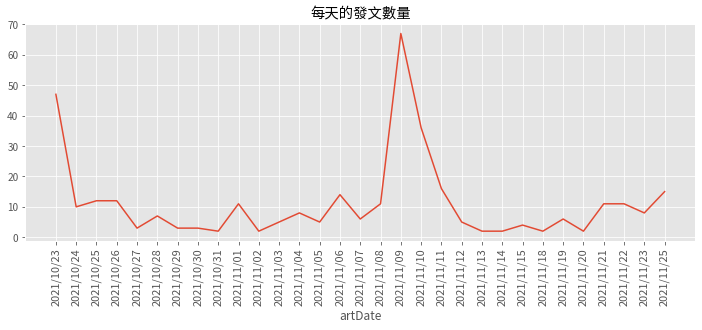

In [ ]:
data_datecount = pd.DataFrame(MetaData.groupby('artDate').size(),columns = ['count'])

plt.figure(figsize=(12,4))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif'] = ['Source Han Sans TW']
plt.title('每天的發文數量')
plt.xlabel('artDate')
plt.xticks(rotation= 90, fontsize=11)
plt.plot(data_datecount.index,data_datecount['count'].tolist())

### 正負向情緒分數聲量折線圖圖
分別畫出文集中，正向（positive）與負向（negative）情緒的折線圖

In [ ]:
#算出每天情緒總和(sentiment_count)
sentiment_count = data_senti.groupby(['artDate','label'],as_index=False).size()
sentiment_count.head()

,artDate,label,size
0,2021-10-23,neg,736
1,2021-10-23,neu,3857
2,2021-10-23,pos,798
3,2021-10-24,neg,166
4,2021-10-24,neu,937


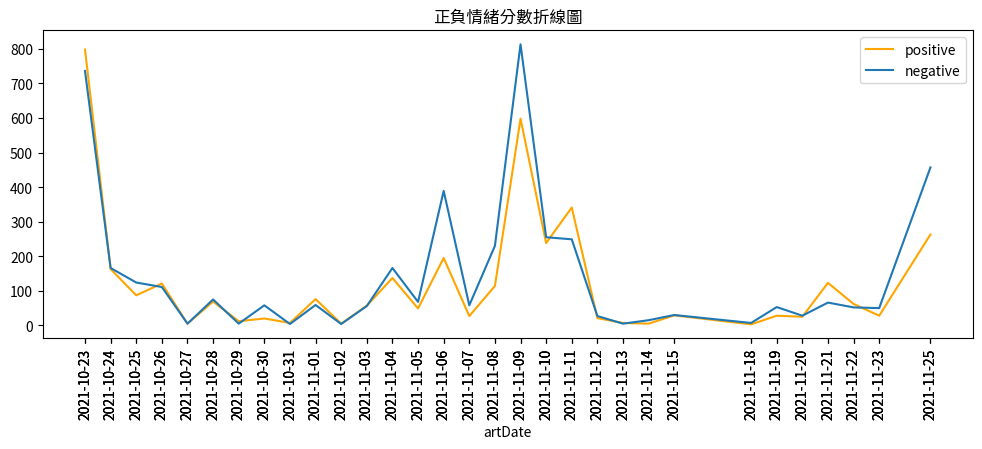

In [ ]:
p = sentiment_count[sentiment_count['label']=='pos']
n = sentiment_count[sentiment_count['label']=='neg']

plt.figure(figsize=(12,4))   # 顯示圖框架大小 (寬,高)
plt.style.use("default")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif'] = ['Source Han Sans TW']
plt.title('正負情緒分數折線圖')
plt.plot(p['artDate'].tolist(), p['size'], label='positive',color="orange")
plt.plot(n['artDate'].tolist(), n['size'], label='negative')
plt.xticks(sentiment_count['artDate'].tolist(),rotation= 90, fontsize=10)
plt.legend() #顯示圖例
#plt.axvline(x='2021-03-18', color="red", ls="-")
plt.xlabel('artDate')
plt.show()

畫出每天的情緒總分數，可以看到11/6、11/9、11/25負面情緒都相當高。

### 正負向情緒分數比例折線圖圖

In [ ]:
sentiment_count_r = sentiment_count.assign(ratio = sentiment_count.groupby(['artDate'], as_index=False)
                      .apply(lambda x: x['size'] / sum(x['size'])).reset_index(level=0, drop=True))

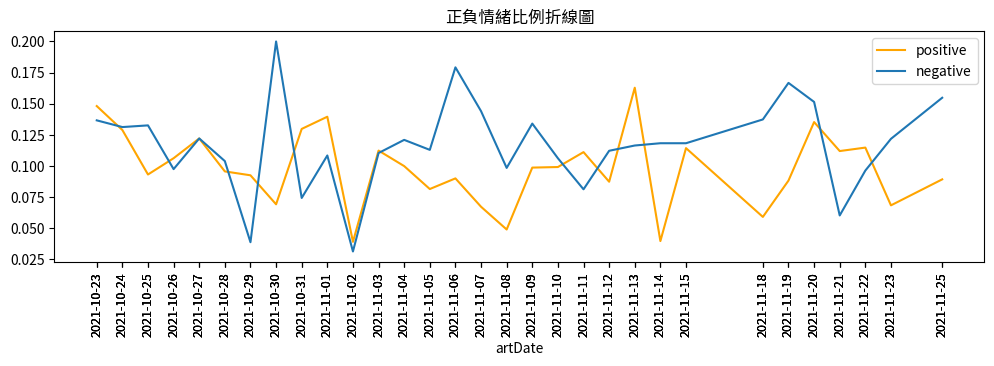

In [ ]:
sentiment_count_r = sentiment_count_r[sentiment_count_r['artDate'] >= '2021-10-23']
p = sentiment_count_r[sentiment_count_r['label']=='pos']
n = sentiment_count_r[sentiment_count_r['label']=='neg']

plt.figure(figsize=(12,3))   # 顯示圖框架大小 (寬,高)
plt.style.use("default")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif'] = ['Source Han Sans TW']
plt.title('正負情緒比例折線圖')
plt.plot(p['artDate'].tolist(), p['ratio'], label='positive',color="orange")
plt.plot(n['artDate'].tolist(), n['ratio'], label='negative')
plt.xticks(sentiment_count_r['artDate'].tolist(),rotation= 90, fontsize=9)
plt.legend() #顯示圖例
#plt.axvline(x=datetime.strptime('2021-10-29', "%Y-%m-%d"), color="red", ls="-")
#plt.axvline(x=datetime.strptime('2021-11-01', "%Y-%m-%d"), color="red", ls="-")
# plt.axvline(x=datetime.strptime('2021-03-25', "%Y-%m-%d"), color="red", ls="-")
# plt.axvline(x=datetime.strptime('2021-03-26', "%Y-%m-%d"), color="red", ls="-")
plt.xlabel('artDate')
plt.show()

透過上圖我們可以發現從10/24到11/22經過12情緒轉折。

### 文字雲
針對不同日期畫出該天的文字雲，如果文字雲中的字詞大小越大，代表出現頻率越高

In [ ]:
def Wc_dict(df, Date, countB, countS):
    wc_df = (df.query('artDate == @Date') # 篩選日期
             .query('size < @countB')# 篩選最大數量(篩掉出現次數多的詞)
             .query('size > @countS')# 篩選最小數量
             .sort_values('size', ascending=False))
    wc_dict = dict(zip(wc_df['word'], wc_df['size'])) #建立成dictionary
    
    return wc_dict
    

#### 2021-11-01 文字雲
媒體人周玉蔻直接點名，大甲鎮瀾宮董事長顏清標「是綁架媽祖的神棍」，要求顏家放媽祖自由，對此，顏清標31日在律師陪同下開記者會，駁斥周玉蔻的「不實指控」，還強調這說法「對全台寺廟跟信徒都不尊重」，根本是故意放話，要把他打成黑五類；但周玉蔻也不甘示弱，再嗆顏清標心虛，有種到大甲媽面前，斬雞頭發誓！
https://tw.news.yahoo.com/%E9%A1%8F%E6%B8%85%E6%A8%99%E9%A7%81%E7%A5%9E%E6%A3%8D%E8%AA%AA-%E5%91%A8%E7%8E%89%E8%94%BB%E5%86%8D%E5%97%86-%E6%95%A2%E6%96%AC%E9%9B%9E%E9%A0%AD%E7%99%BC%E8%AA%93%E5%97%8E-095746361.html

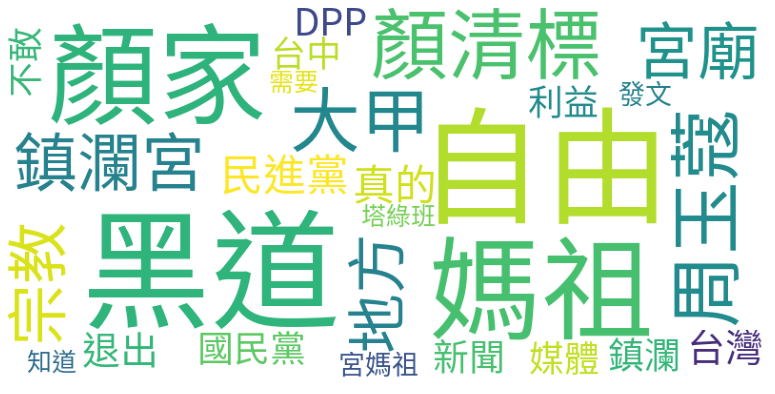

In [ ]:
dict_1101 = Wc_dict(word_count_artDate,"2021-11-01",900,10) 

font = './SourceHanSansTW-Regular.otf' #中文字型路徑
wordcloud = WordCloud(background_color='white',width=800, height = 400, font_path=font, colormap='viridis')
wordcloud.generate_from_frequencies(dict_1101)
plt.figure(figsize = (14,7))
plt.imshow(wordcloud)
plt.axis("off") #把作圖的座標軸關掉 
plt.show()

#### 2021-11-06 文字雲
大家在討論顏清標欠錢的八卦及塔綠班代表民進黨<br>
台中地方人士爆顏清標欠債6000多萬 前沙鹿鎮長陳孟森妻證實
https://news.ltn.com.tw/news/politics/breakingnews/3728081

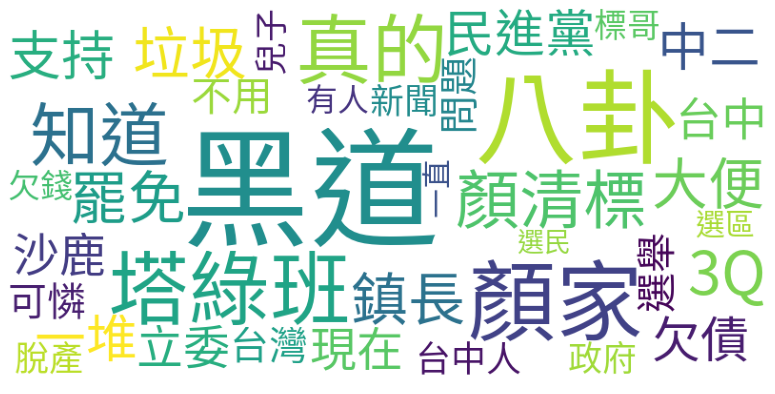

In [ ]:
dict_1106 = Wc_dict(word_count_artDate,"2021-11-06",900,20) 

font = './SourceHanSansTW-Regular.otf' #中文字型路徑
wordcloud = WordCloud(background_color='white',width=800, height = 400, font_path=font, colormap='viridis')
wordcloud.generate_from_frequencies(dict_1106)
plt.figure(figsize = (14,7))
plt.imshow(wordcloud)
plt.axis("off") #把作圖的座標軸關掉 
plt.show()

#### 2021-11-09 文字雲
泰雅渡假村爆爭產　創辦子控顏清標涉，該文中有有提到黑道、塔綠班等字。
https://www.ptt.cc/bbs/Gossiping/M.1636439157.A.F8E.html

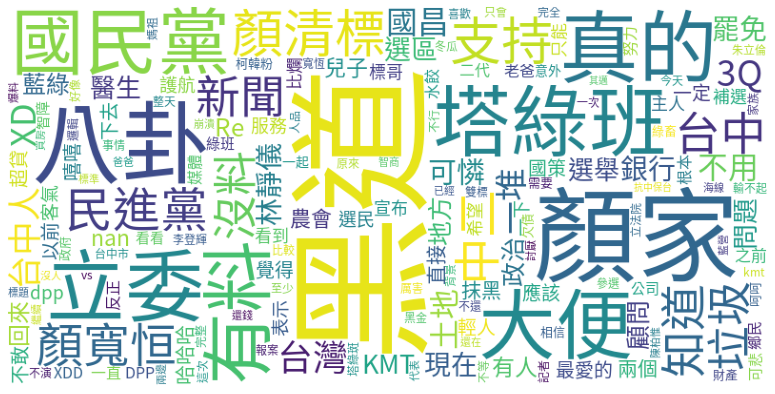

In [ ]:
dict_1109 = Wc_dict(word_count_artDate,"2021-11-09",900,20) 

font = './SourceHanSansTW-Regular.otf' #中文字型路徑
wordcloud = WordCloud(background_color='white',width=800, height = 400, font_path=font, colormap='viridis')
wordcloud.generate_from_frequencies(dict_1109)
plt.figure(figsize = (14,7))
plt.imshow(wordcloud)
plt.axis("off") #把作圖的座標軸關掉 
plt.show()

#### 2021-11-11 文字雲
父親顏清標屢遭抹黑 顏寬恒不忍了喊：慈悲無用「將提告」
https://tw.news.yahoo.com/%E7%88%B6%E8%A6%AA%E9%A1%8F%E6%B8%85%E6%A8%99%E5%B1%A2%E9%81%AD%E6%8A%B9%E9%BB%91-%E9%A1%8F%E5%AF%AC%E6%81%92%E4%B8%8D%E5%BF%8D%E4%BA%86%E5%96%8A-%E6%85%88%E6%82%B2%E7%84%A1%E7%94%A8-%E5%B0%87%E6%8F%90%E5%91%8A-052213934.html

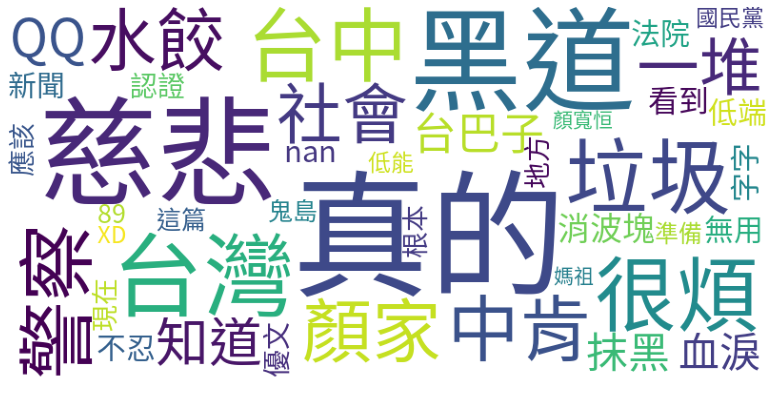

In [ ]:
dict_1111 = Wc_dict(word_count_artDate,"2021-11-11",900,20)

font = './SourceHanSansTW-Regular.otf' #中文字型路徑
wordcloud = WordCloud(background_color='white',width=800, height = 400, font_path=font, colormap='viridis')
wordcloud.generate_from_frequencies(dict_1111)
plt.figure(figsize = (14,7))
plt.imshow(wordcloud)
plt.axis("off") #把作圖的座標軸關掉 
plt.show()

#### 2021-11-25 文字雲
「大便」是因為網友多次提到「大便立委」。

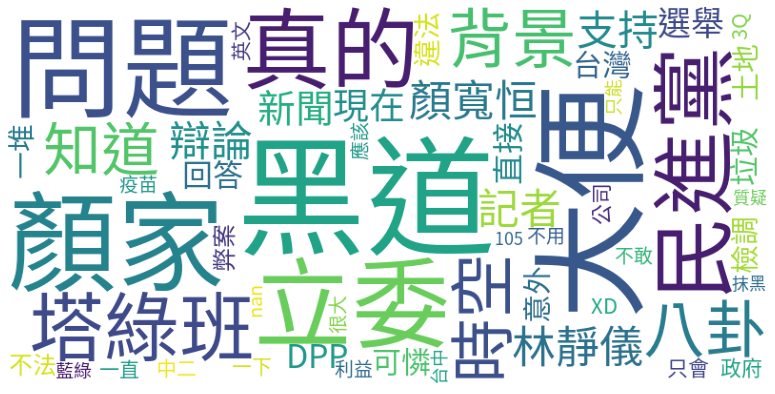

In [ ]:
dict_1125 = Wc_dict(word_count_artDate,"2021-11-25",900,20) #篩掉超過450次(如鮭魚)及小於50次的字詞

font = './SourceHanSansTW-Regular.otf' #中文字型路徑
wordcloud = WordCloud(background_color='white',width=800, height = 400, font_path=font, colormap='viridis')
wordcloud.generate_from_frequencies(dict_1125)
plt.figure(figsize = (14,7))
plt.imshow(wordcloud)
plt.axis("off") #把作圖的座標軸關掉 
plt.show()

### 正負情緒文章數量統計圖

In [ ]:
data_senti_date = data_senti.groupby(['artDate','label'], as_index=False).size()
data_senti_date

,artDate,label,size
0,2021-10-23,neg,736
1,2021-10-23,neu,3857
2,2021-10-23,pos,798
3,2021-10-24,neg,166
4,2021-10-24,neu,937
...,...,...,...
88,2021-11-23,neu,333
89,2021-11-23,pos,28
90,2021-11-25,neg,457
91,2021-11-25,neu,2234


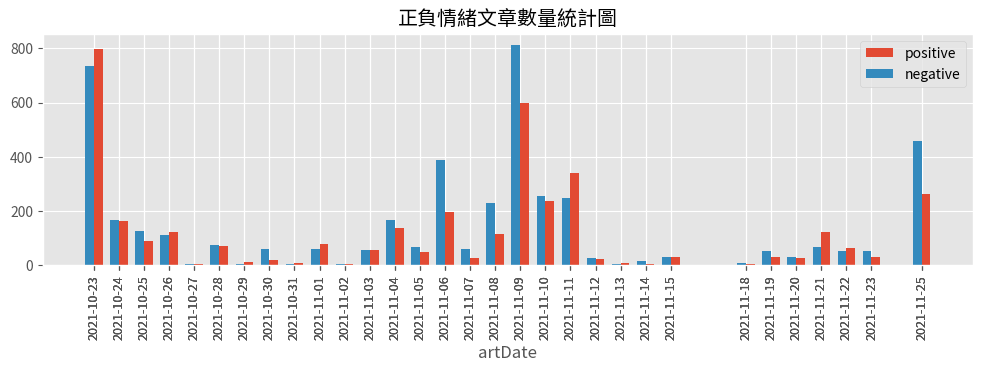

In [ ]:
ap = data_senti_date[(data_senti_date["label"]=="pos")]
an = data_senti_date[(data_senti_date["label"]=="neg")]

plt.figure(figsize=(12,3))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['Source Han Sans TW'] #使中文能正常顯示
plt.title('正負情緒文章數量統計圖')
plt.xlabel('artDate')
plt.bar(ap['artDate'],ap['size'],align="edge",width=0.35,label="positive")
plt.bar(an['artDate'],an['size'],align="edge",width=-0.35,label="negative")
plt.legend()
plt.xticks(data_senti_date['artDate'].tolist(),rotation= 90, fontsize=9)
plt.xlabel('artDate')
plt.show()

###正負面情緒文章常用字

In [ ]:
# 選出兩類文章最高的20個字
top_n = 20
neg_word = word_count[word_count["label"]=="neg"].head(top_n).sort_values(by=['size']) # 負面情緒 
pos_word = word_count[word_count["label"]=="pos"].head(top_n).sort_values(by=['size']) # 正面情緒
neg_word.head(5)

,label,word,size
6612,neg,知道,140
457,neg,一堆,141
2705,neg,國民黨,158
2306,neg,台灣,163
4862,neg,智障,171


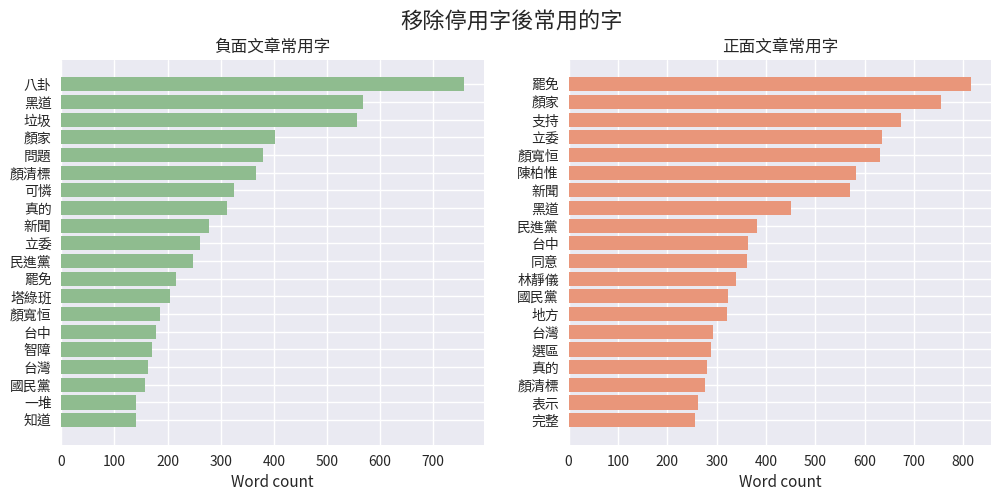

In [ ]:
plt.figure(figsize=(12,5))   
plt.style.use('seaborn') 
plt.rcParams['font.sans-serif'] = ['Source Han Sans TW']  # 設定中文

plt.subplot(121)
plt.title('負面文章常用字')
plt.xlabel('Word count')
plt.barh(neg_word['word'],neg_word['size'],color="darkseagreen")

plt.subplot(122)
plt.title('正面文章常用字')
plt.xlabel('Word count')
plt.barh(pos_word['word'],pos_word['size'],color="darksalmon")

# 最上面的標題
plt.suptitle('移除停用字後常用的字', fontsize=16)
plt.show()

### 情緒關鍵字
把正面和負面的文章挑出來，並和斷詞結果合併

In [ ]:
article_type = (token_df.merge(data_liwc, on='word')
                .groupby(['artUrl', 'sentiments'], as_index=False)
                .size()
                .pivot_table(index='artUrl', columns='sentiments', values='size', fill_value=0)
                .reset_index(['artUrl'])
               )
article_type.head()

sentiments,artUrl,negative,positive
0,https://www.ptt.cc/bbs/Gossiping/M.1634980712....,61,50
1,https://www.ptt.cc/bbs/Gossiping/M.1634981115....,27,42
2,https://www.ptt.cc/bbs/Gossiping/M.1634981688....,22,32
3,https://www.ptt.cc/bbs/Gossiping/M.1634982130....,7,2
4,https://www.ptt.cc/bbs/Gossiping/M.1634982397....,3,6


In [ ]:
article_type['type'] = article_type.apply(lambda x: 'positive' if x['positive'] > x['negative'] else 'negative',axis=1)
article_type.groupby('type', as_index=False).size()

,type,size
0,negative,200
1,positive,144


In [ ]:
positive_article = article_type[article_type["type"]=="positive"].merge(data, how = 'left', on = 'artUrl')
negative_article = article_type[article_type["type"]=="negative"].merge(data, how = 'left', on = 'artUrl')

In [ ]:
negative_article

,artUrl,negative,positive,type,artDate,sentence,document,word
0,https://www.ptt.cc/bbs/Gossiping/M.1634980712....,61,50,negative,2021-10-23,Re:[新聞]快訊／陳柏惟罷免案「總投票率52.63%」其實當初陳柏惟擊落顏家板上是很振奮的...,0,Re 新聞 快訊 陳柏惟 罷免案 投票率 52.63% 當初 陳柏惟 擊落 顏家 板上 很振...
1,https://www.ptt.cc/bbs/Gossiping/M.1634980712....,61,50,negative,2021-10-23,但是反罷免的很多喔,0,反罷免
2,https://www.ptt.cc/bbs/Gossiping/M.1634980712....,61,50,negative,2021-10-23,先去地方歷練,1,先去 地方 歷練
3,https://www.ptt.cc/bbs/Gossiping/M.1634980712....,61,50,negative,2021-10-23,真的脫離地方會很慘,2,真的 脫離 地方 很慘
4,https://www.ptt.cc/bbs/Gossiping/M.1634980712....,61,50,negative,2021-10-23,所以默默賺千碗公才是真理XD,3,默默 賺千 碗公 真理 XD
...,...,...,...,...,...,...,...,...
26991,https://www.ptt.cc/bbs/Gossiping/M.1637854174....,24,21,negative,2021-11-25,打郭董的BNT還敢投給大便就太下系下,35314,郭董 BNT 還敢 投給 大便 太下 系下
26992,https://www.ptt.cc/bbs/Gossiping/M.1637854174....,24,21,negative,2021-11-25,井,35315,
26993,https://www.ptt.cc/bbs/Gossiping/M.1637854174....,24,21,negative,2021-11-25,醫生裡除了牙醫竟然有這麼低能的咖,35316,醫生裡 牙醫 低能
26994,https://www.ptt.cc/bbs/Gossiping/M.1637854174....,24,21,negative,2021-11-25,這水準,35317,這水準


#### 情緒關鍵字:負面情緒文章

In [ ]:
negative_article = (negative_article.merge(data_liwc, on='word')
                    .groupby(['word', 'sentiments'], as_index=False)
                    .size()
                    .sort_values('size', ascending = False))

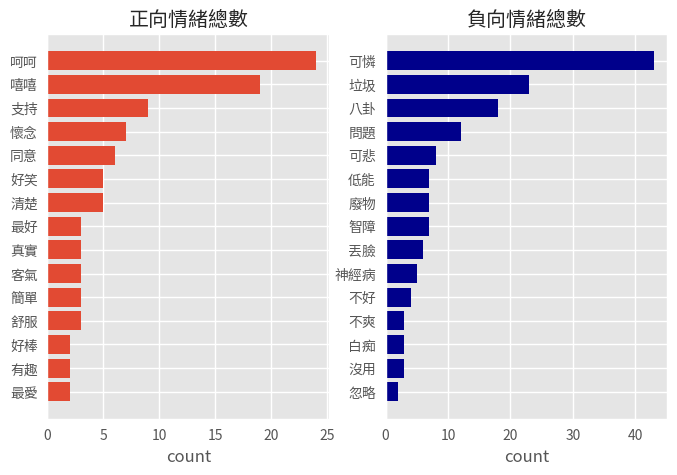

In [ ]:
p_sum = negative_article[negative_article["sentiments"]=="positive"].head(15).sort_values(by=['size'])
n_sum = negative_article[negative_article["sentiments"]=="negative"].head(15).sort_values(by=['size'])

plt.figure(figsize=(8,5))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['Source Han Sans TW'] #使中文能正常顯示

plt.subplot(121)
plt.title('正向情緒總數')
plt.xlabel('count')
plt.barh(p_sum['word'],p_sum['size'])

plt.subplot(122)
plt.title('負向情緒總數')
plt.xlabel('count')
plt.barh(n_sum['word'],n_sum['size'],color="darkblue")


plt.show()

#### 情緒關鍵字:正面情緒文章

In [ ]:
positive_article = (positive_article.merge(data_liwc, on='word')
                    .groupby(['word', 'sentiments'], as_index=False)
                    .size()
                    .sort_values('size', ascending = False))

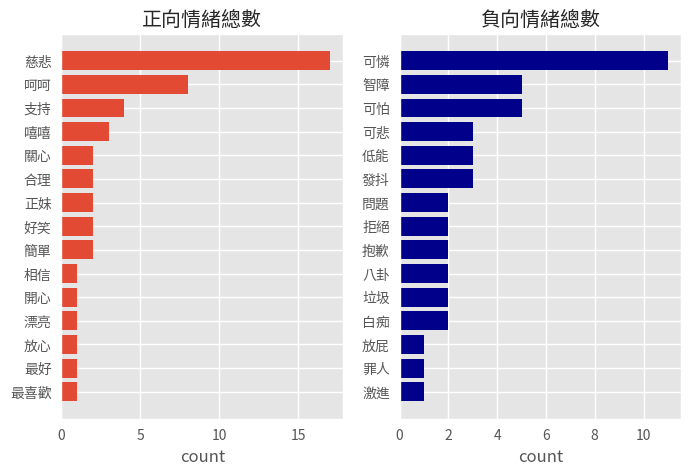

In [ ]:
p_sum = positive_article[positive_article["sentiments"]=="positive"].head(15).sort_values(by=['size'])
n_sum = positive_article[positive_article["sentiments"]=="negative"].head(15).sort_values(by=['size'])

plt.figure(figsize=(8,5))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['Source Han Sans TW'] #使中文能正常顯示

plt.subplot(121)
plt.title('正向情緒總數')
plt.xlabel('count')
plt.barh(p_sum['word'],p_sum['size'])

plt.subplot(122)
plt.title('負向情緒總數')
plt.xlabel('count')
plt.barh(n_sum['word'],n_sum['size'],color="darkblue")


plt.show()
#正面情緒多在200以下、負面大多>200

## 3. TF-IDF
TF-IDF 是一種統計方法，可用來評估單詞對於文件的集合的重要程度  


In [ ]:
#計算各詞彙在各文章中出現的次數
word_count_artUrl = token_df.groupby(['artUrl','word'],as_index=False).size()
word_count_artUrl.rename(columns={'size': 'count'}, inplace=True)

In [ ]:
word_count_artUrl

,artUrl,word,count
0,https://www.ptt.cc/bbs/Gossiping/M.1634980712....,18,1
1,https://www.ptt.cc/bbs/Gossiping/M.1634980712....,2266,1
2,https://www.ptt.cc/bbs/Gossiping/M.1634980712....,311,1
3,https://www.ptt.cc/bbs/Gossiping/M.1634980712....,3Q,11
4,https://www.ptt.cc/bbs/Gossiping/M.1634980712....,50,1
...,...,...,...
96778,https://www.ptt.cc/bbs/Gossiping/M.1637854174....,鬥爭,1
96779,https://www.ptt.cc/bbs/Gossiping/M.1637854174....,黑人,1
96780,https://www.ptt.cc/bbs/Gossiping/M.1637854174....,黑道,3
96781,https://www.ptt.cc/bbs/Gossiping/M.1637854174....,點後限電,1


### 3.1 計算每篇文章的詞數

In [ ]:
total_words = token_df.groupby(['artUrl'],as_index=False).size()
total_words.rename(columns={'size': 'total'}, inplace=True)
total_words

,artUrl,total
0,https://www.ptt.cc/bbs/Gossiping/M.1634980712....,1279
1,https://www.ptt.cc/bbs/Gossiping/M.1634981115....,635
2,https://www.ptt.cc/bbs/Gossiping/M.1634981688....,819
3,https://www.ptt.cc/bbs/Gossiping/M.1634982130....,98
4,https://www.ptt.cc/bbs/Gossiping/M.1634982397....,105
...,...,...
343,https://www.ptt.cc/bbs/Gossiping/M.1637852410....,610
344,https://www.ptt.cc/bbs/Gossiping/M.1637852967....,109
345,https://www.ptt.cc/bbs/Gossiping/M.1637853294....,146
346,https://www.ptt.cc/bbs/Gossiping/M.1637853906....,691


### 3.2 合併需要的資料欄位
- 合併 **每個詞彙在每個文章中出現的次數** 與 **每篇文章的詞數**
- 新增各個詞彙在所有詞彙中的總數欄位

In [ ]:
yan_words = word_count_artUrl.merge(total_words,on = 'artUrl',how = 'left')
yan_words

,artUrl,word,count,total
0,https://www.ptt.cc/bbs/Gossiping/M.1634980712....,18,1,1279
1,https://www.ptt.cc/bbs/Gossiping/M.1634980712....,2266,1,1279
2,https://www.ptt.cc/bbs/Gossiping/M.1634980712....,311,1,1279
3,https://www.ptt.cc/bbs/Gossiping/M.1634980712....,3Q,11,1279
4,https://www.ptt.cc/bbs/Gossiping/M.1634980712....,50,1,1279
...,...,...,...,...
96778,https://www.ptt.cc/bbs/Gossiping/M.1637854174....,鬥爭,1,498
96779,https://www.ptt.cc/bbs/Gossiping/M.1637854174....,黑人,1,498
96780,https://www.ptt.cc/bbs/Gossiping/M.1637854174....,黑道,3,498
96781,https://www.ptt.cc/bbs/Gossiping/M.1637854174....,點後限電,1,498


### 3.3 計算 tf-idf 值
- 以每篇文章爲單位，計算每個詞彙的 tf-idf 值  
    - TF (Term Frequency):某一個詞彙在某一個文件中所出現的頻率。  
        詞彙在該文件中出現次數 / 該文件中詞彙總數  
    - IDF (Inverse Document Frequent):為文件數除以某特定詞彙有被多少文件所提及的數量取log。評估詞彙在文集的獨特性  
        log( 總文件數量 / 包含該詞彙的文件數量 ) 

In [ ]:
#計算tf
yan_words_tf_idf = yan_words.assign(tf = yan_words.iloc[:,2]/yan_words.iloc[:,3])

In [ ]:
# 計算每個詞彙出現在幾篇文章中
idf_df = yan_words.groupby(['word'],as_index=False).size()
yan_words_tf_idf = yan_words_tf_idf.merge(idf_df,on = 'word',how = 'left')

In [ ]:
#計算idf
yan_words_tf_idf = yan_words_tf_idf.assign(idf = yan_words_tf_idf.iloc[:,5]
                                               .apply(lambda x: math.log((len(total_words)/x),10)))

yan_words_tf_idf = yan_words_tf_idf.drop(labels=['size'],axis=1)

In [ ]:
#計算tf*idf
yan_words_tf_idf = yan_words_tf_idf.assign(tf_idf = yan_words_tf_idf.iloc[:,4]*yan_words_tf_idf.iloc[:,5])

In [ ]:
yan_words_tf_idf.head()

,artUrl,word,count,total,tf,idf,tf_idf
0,https://www.ptt.cc/bbs/Gossiping/M.1634980712....,18,1,1279,0.000782,1.286307,0.001006
1,https://www.ptt.cc/bbs/Gossiping/M.1634980712....,2266,1,1279,0.000782,2.240549,0.001752
2,https://www.ptt.cc/bbs/Gossiping/M.1634980712....,311,1,1279,0.000782,1.286307,0.001006
3,https://www.ptt.cc/bbs/Gossiping/M.1634980712....,3Q,11,1279,0.008600,0.377226,0.003244
4,https://www.ptt.cc/bbs/Gossiping/M.1634980712....,50,1,1279,0.000782,1.462398,0.001143


### 3.4 檢視結果

In [ ]:
# 選出每篇文章，tf-idf值最大的五個詞
group = yan_words_tf_idf.groupby("artUrl").apply(lambda x : x.nlargest(5, "tf_idf"))

In [ ]:
group.loc[:,["word","tf_idf"]][0:15]

word    tf_idf
artUrl                                                                
https://www.ptt.cc/bbs/Gossiping/M.1634980712.A... 317    惡意  0.010291
                                                   172    反中  0.008071
                                                   297    形態  0.007686
                                                   322    意識  0.007232
                                                   577    罷免  0.006913
https://www.ptt.cc/bbs/Gossiping/M.1634981115.A... 814   二分法  0.037785
                                                   856   台中人  0.014383
                                                   769    3Q  0.010099
                                                   908    崩潰  0.009585
                                                   875    喜歡  0.008496
https://www.ptt.cc/bbs/Gossiping/M.1634981688.A... 1499   聖地  0.030669
                                                   1227  台中人  0.020992
                                                   1349  搖擺州  0.018620
                                                   1402   民主  0.015074
                                                   1226   台中  0.014655

#### 計算整個文集中較常 tf-idf 值高的字

In [ ]:
# 從每篇文章挑選出tf-idf最大的十個詞
(yan_words_tf_idf.groupby("artUrl").apply(lambda x : x.nlargest(10, "tf_idf")).reset_index(drop=True)
# 計算每個詞被選中的次數
.groupby(['word'],as_index=False).size()
).sort_values('size', ascending=False).head(10) #排序看前十名

,word,size
2777,黑道,25
2246,罷免,20
1115,大便,16
1793,林靜儀,15
679,八卦,11
2513,輸不起,11
338,中二,9
2637,銀行,9
897,台中人,9
956,周玉蔻,8


## 將資料切成訓練集與測試集
### 根據7:3的比例切分資料集
利用 sklearn 中的 train_test_split 函數將 `raw_data` 隨機切成 7:3，設置 random_state 讓每次切分的結果一致。`y_train`和`y_test`分別為訓練資料和測試資料的預測目標（每個句子所屬的書名id）。

In [ ]:
# 把整個資料集七三切
dtf_train, dtf_test = model_selection.train_test_split(data_senti, stratify=data_senti["label"],
                                                       test_size=0.3, random_state=2021)
## get target
y_train = dtf_train["label"].values
y_test = dtf_test["label"].values

In [ ]:
# 看一下各個資料集切分的比例，應該要一致
print(f"raw data percentage :\n{data_senti['label'].value_counts(normalize=True) * 100}")
print(f"\ntrain percentage :\n{dtf_train['label'].value_counts(normalize=True) * 100}")
print(f"\ntest percentage :\n{dtf_test['label'].value_counts(normalize=True) * 100}")

raw data percentage :
neu    77.292016
neg    12.342267
pos    10.365717
Name: label, dtype: float64

train percentage :
neu    77.291218
neg    12.343463
pos    10.365319
Name: label, dtype: float64

test percentage :
neu    77.293877
neg    12.339475
pos    10.366648
Name: label, dtype: float64


##將文章轉為 DTM
+ 4.1 簡單範例介紹DTM
+ 4.2 套入正式資料集訓練

### 4.1 簡單範例介紹DTM

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
corpus = [
     '顏清標 顏清標 顏清標',
     '國民黨 顏清標',
     '國民黨 民進黨 立委',
     '國民黨 民進黨',
]
vectorizer = CountVectorizer() # ngram_range=(1, 2)
X = vectorizer.fit_transform(corpus)
vocabulary = vectorizer.get_feature_names()

# 轉成dataframe來看
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())

print(f"documents: {X.shape[0]} terms: {X.shape[1]}")
print(f"\nterms:\n {vocabulary}") # DTM 字詞可以藉由 get_feature_names 查看
print(f"\nDTM array:\n {X.toarray()}") # DTM的資料結構，裡面代表字詞的頻率
DTM_df

documents: 4 terms: 4

terms:
 ['國民黨', '民進黨', '立委', '顏清標']

DTM array:
 [[0 0 0 3]
 [1 0 0 1]
 [1 1 1 0]
 [1 1 0 0]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,國民黨,民進黨,立委,顏清標
0,0,0,0,3
1,1,0,0,1
2,1,1,1,0
3,1,1,0,0


### 4.2 套入正式的資料集
+  模型訓練範例: logistic regression + cv tokenizer

In [ ]:
## 定義切分資料的 vectorizer
# Count (classic BoW) 
cv_vectorizer = feature_extraction.text.CountVectorizer(max_features=10000)  # , ngram_range=(1,2)
cv_vectorizer_min = feature_extraction.text.CountVectorizer(max_features=10000,min_df = 10) # , ngram_range=(1,2)

# # Tf-Idf (advanced variant of BoW)
# tfidf_vectorizer = feature_extraction.text.TfidfVectorizer(max_features=100) # , ngram_range=(1,2)

In [ ]:
corpus = dtf_train["word"]

+ 過濾詞頻比較

In [ ]:
# 沒有過濾最低詞頻的 vectorizer
cv_vectorizer.fit(corpus)
X_train = cv_vectorizer.transform(corpus)
vocabulary = cv_vectorizer.get_feature_names()

# 過濾至少要出現10次 vectorizer
cv_vectorizer_min.fit(corpus)
X_train_min = cv_vectorizer_min.transform(corpus)
vocabulary_min = cv_vectorizer_min.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
print(f"without term cut off: posts {X_train.shape[0]} words: {X_train.shape[1]} ({len(vocabulary)})") 
print(f"with term cut off: posts {X_train_min.shape[0]} words: {X_train_min.shape[1]} ({len(vocabulary_min)})") 
X_train

without term cut off: posts 25074 words: 10000 (10000)
with term cut off: posts 25074 words: 1399 (1399)


<25074x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 78828 stored elements in Compressed Sparse Row format>

In [ ]:
# 定義分類器模型
classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs')

In [ ]:
# 定義模型訓練組合

## pipeline: 分類器 + 資料處理 vectorizer
model = pipeline.Pipeline([("vectorizer", cv_vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train, y_train)

## test
X_test = dtf_test["word"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Accuracy: 0.95
Auc: 0.96
Detail:
              precision    recall  f1-score   support

         neg       0.96      0.82      0.88      1326
         neu       0.95      1.00      0.97      8306
         pos       0.99      0.77      0.86      1114

    accuracy                           0.95     10746
   macro avg       0.97      0.86      0.91     10746
weighted avg       0.95      0.95      0.95     10746



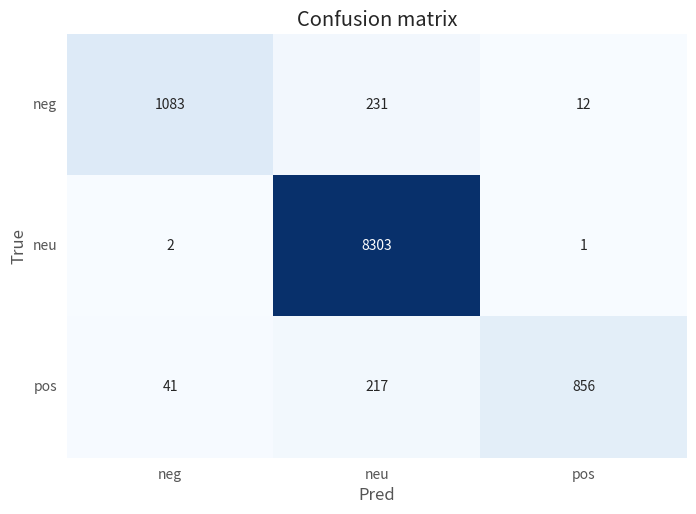

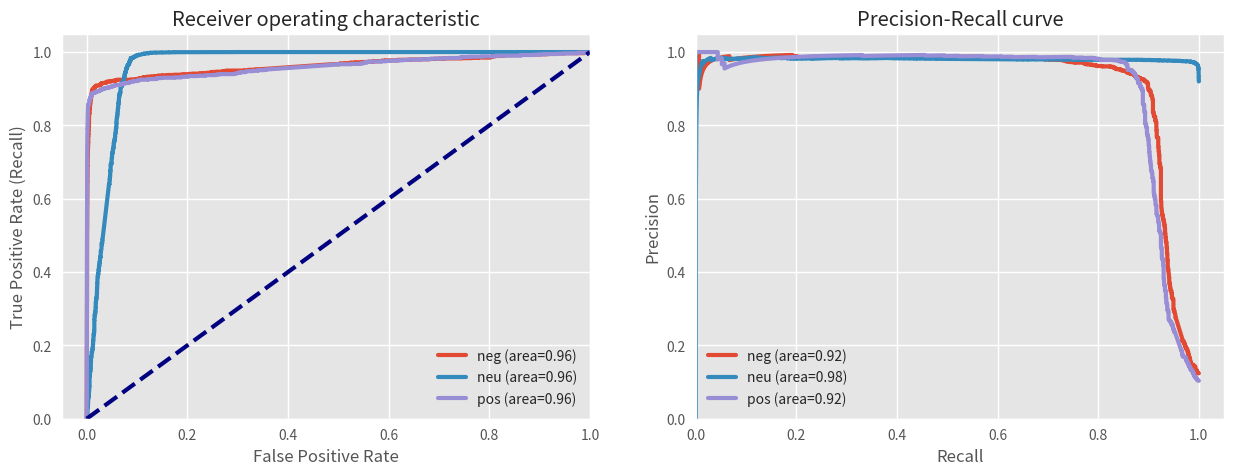

In [ ]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test_array, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

In [ ]:
# 定義模型訓練組合

## pipeline: 分類器 + 資料處理 vectorizer
model = pipeline.Pipeline([("vectorizer", cv_vectorizer_min),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train_min, y_train)

## test
X_test = dtf_test["word"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Accuracy: 0.94
Auc: 0.91
Detail:
              precision    recall  f1-score   support

         neg       0.95      0.78      0.86      1326
         neu       0.94      1.00      0.97      8306
         pos       0.98      0.73      0.84      1114

    accuracy                           0.94     10746
   macro avg       0.96      0.83      0.89     10746
weighted avg       0.95      0.94      0.94     10746



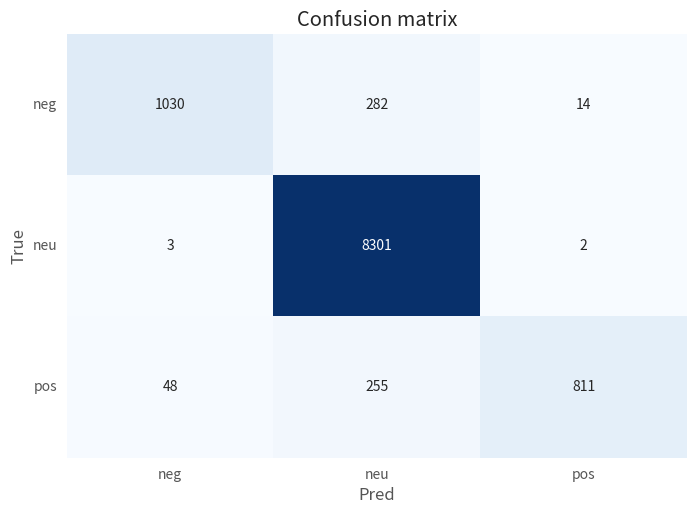

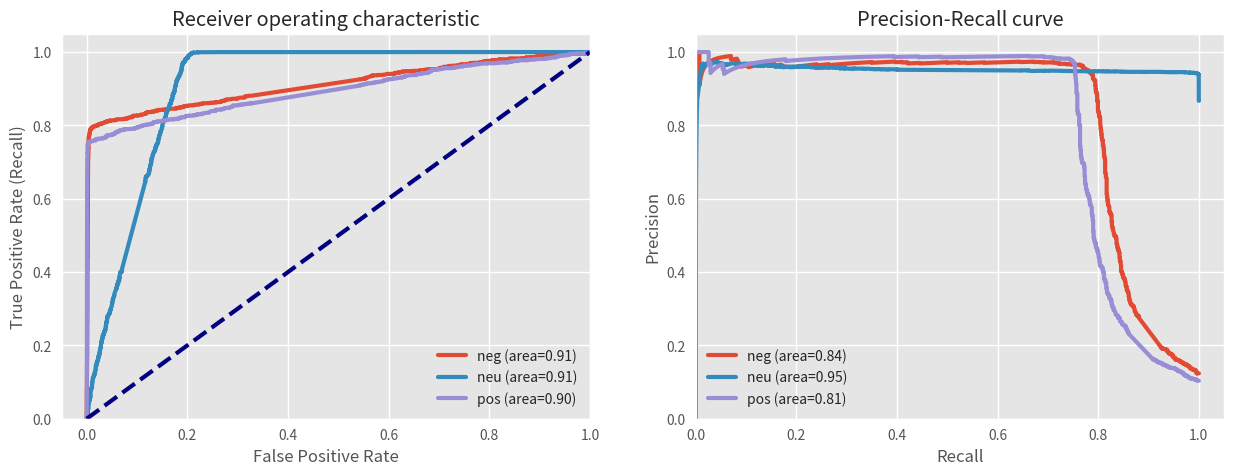

In [ ]:
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test_array, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

### 4.3. 定義建模與畫圖的函數
因為不同的 classifier 可以和不同的 vectorizer 搭配，為了簡化程式，我們將建模與畫圖的步驟定義成函數

In [ ]:
def model_predict(train_data, test_data, train_label, vectorizer, classifier, return_classifier = False):
    
    start = time.time()

    # sentence to DTM
    vectorizer.fit(train_data) # fit(corpus)
    X_train = vectorizer.transform(corpus)    
    
    ## pipeline: 分類器 + 資料處理 vectorizer
    model = pipeline.Pipeline([("vectorizer", vectorizer),  
                               ("classifier", classifier)])
    ## train classifier
    model["classifier"].fit(X_train, train_label)
    
    ## test
    X_test = test_data.values
    predicted = model.predict(X_test)
    predicted_prob = model.predict_proba(X_test)
    
    end = time.time()
    print(f"time costing: {end - start}")
    
    if return_classifier:
        return predicted, predicted_prob, classifier       
    else:
        return predicted, predicted_prob

In [ ]:
def evaluate(true, predicted, predicted_prob):

    classes = np.unique(true)
    true_array = pd.get_dummies(true, drop_first=False).values

    ## Accuracy, Precision, Recall
    Accuracy = metrics.accuracy_score(true, predicted)
    AUC = metrics.roc_auc_score(true_array, predicted_prob, 
                                multi_class="ovr")
    
    print("Accuracy:",  round(Accuracy,2))
    print("Auc:", round(AUC,2))
    print("Detail:")
    print(metrics.classification_report(true, predicted))
    
    ## Plot confusion matrix
    cm = metrics.confusion_matrix(true, predicted)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
                cbar=False)
    ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
           yticklabels=classes, title="Confusion matrix")
    plt.yticks(rotation=0)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

    ## Plot roc
    roc_auc_dict = {}
    for i in range(len(classes)):
        fpr, tpr, thresholds = metrics.roc_curve(true_array[:,i],  
                               predicted_prob[:,i])
        roc_auc = metrics.auc(fpr, tpr)
        ax[0].plot(fpr, tpr, lw=3, 
                  label='{0} (area={1:0.2f})'.format(classes[i], roc_auc)
                   )
        roc_auc_dict[classes[i]] = {"fpr":fpr,"tpr": tpr, "roc_auc": roc_auc} 
        
    ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
    ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
              xlabel='False Positive Rate', 
              ylabel="True Positive Rate (Recall)", 
              title="Receiver operating characteristic")
    ax[0].legend(loc="lower right")
    ax[0].grid(True)

    ## Plot precision-recall curve
    for i in range(len(classes)):
        precision, recall, thresholds = metrics.precision_recall_curve(
                     true_array[:,i], predicted_prob[:,i])
        ax[1].plot(recall, precision, lw=3, 
                   label='{0} (area={1:0.2f})'.format(classes[i], 
                                      metrics.auc(recall, precision))
                  )
    ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
              ylabel="Precision", title="Precision-Recall curve")
    ax[1].legend(loc="best")
    ax[1].grid(True)
    plt.show()
    
    return Accuracy, AUC, roc_auc_dict

#### step 1 定義 vectorizer

In [ ]:
cut_off = 0 # 經由實驗發現詞頻不篩模型會比較準，但需要較長的時間，同學可以自行取捨
vec_cv = feature_extraction.text.CountVectorizer(max_features=10000, min_df = cut_off) # , ngram_range=(1,2)
vec_tfidf = feature_extraction.text.TfidfVectorizer(max_features=10000, min_df = cut_off) # , ngram_range=(1,2)

#### step 2 定義 classifier

In [ ]:
cla_lg = LogisticRegression(multi_class='multinomial', solver='lbfgs')
cla_svc = svm.SVC(probability=True)
cla_rf  = ensemble.RandomForestClassifier()

#### step 3 定義測試和訓練資料集

In [ ]:
train_data = dtf_train["word"]
test_data = dtf_test["word"]
train_label = y_train
test_label = y_test

In [ ]:
## 創造一個空的dataframe 和 list 存模型結果
result_df = pd.DataFrame(columns=['model_type', 'Accuracy', 'AUC'])
roc_auc_all = {}

## 5.比較不同模型和資料組合的訓練結果

### 5.1 Model Building : logistic regression
logistic regression 原本是用來做二元分類的，如果要多元分類需要另外指定
+ 預設是預測二元分布(binomial probability)的機率，需要改為多元分布(multinomial probability)
+ [參考: Multinomial Logistic Regression With Python](https://machinelearningmastery.com/multinomial-logistic-regression-with-python/)

model type: CV + logistic regression


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


time costing: 3.664167642593384
Accuracy: 0.95
Auc: 0.96
Detail:
              precision    recall  f1-score   support

         neg       0.96      0.82      0.88      1326
         neu       0.95      1.00      0.97      8306
         pos       0.99      0.77      0.86      1114

    accuracy                           0.95     10746
   macro avg       0.97      0.86      0.91     10746
weighted avg       0.95      0.95      0.95     10746



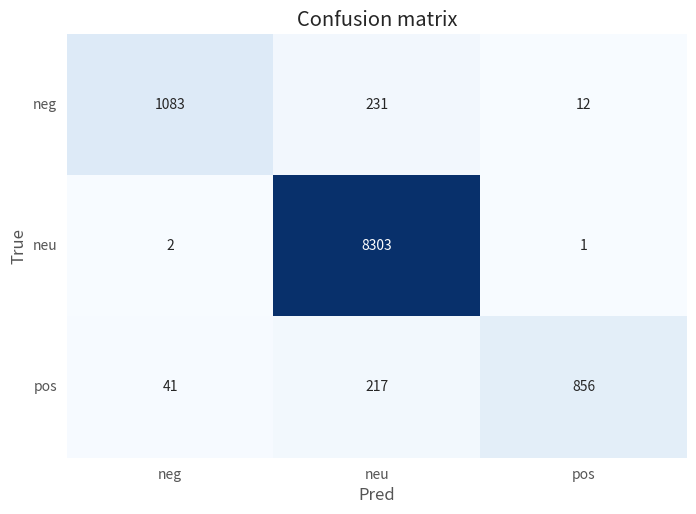

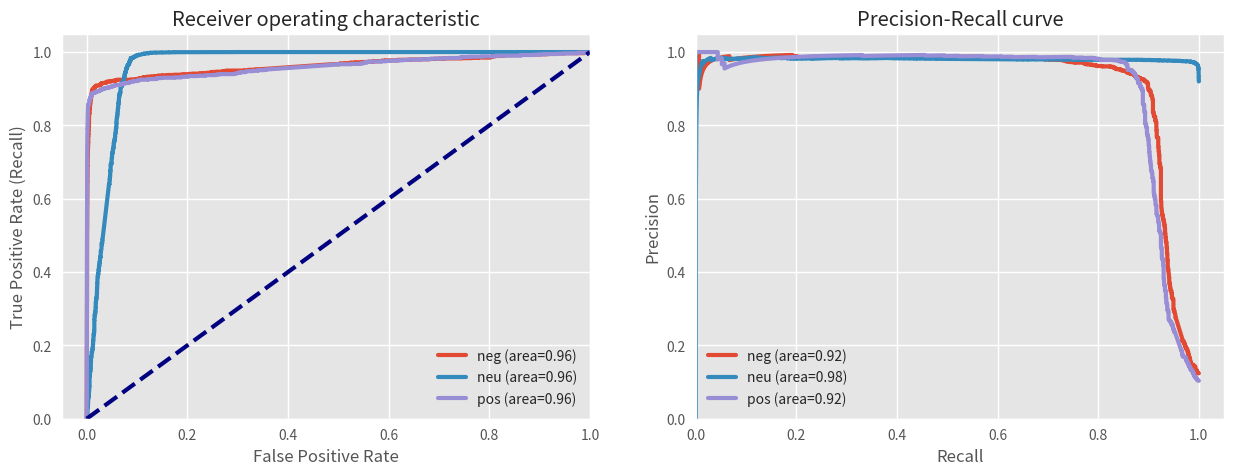

In [ ]:
model_type = "CV + logistic regression"
print(f"model type: {model_type}")
# 訓練模型
pred_l , pred_pro_l, logisticRegr = model_predict(dtf_train["word"], dtf_test["word"], y_train,
                                 vectorizer = vec_cv, classifier = cla_lg,
                                 return_classifier = True)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred_l, pred_pro_l)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

model type: TF-IDF + logistic regression


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


time costing: 3.5636496543884277
Accuracy: 0.93
Auc: 0.96
Detail:
              precision    recall  f1-score   support

         neg       0.96      0.71      0.81      1326
         neu       0.92      1.00      0.96      8306
         pos       0.99      0.68      0.81      1114

    accuracy                           0.93     10746
   macro avg       0.96      0.80      0.86     10746
weighted avg       0.93      0.93      0.93     10746



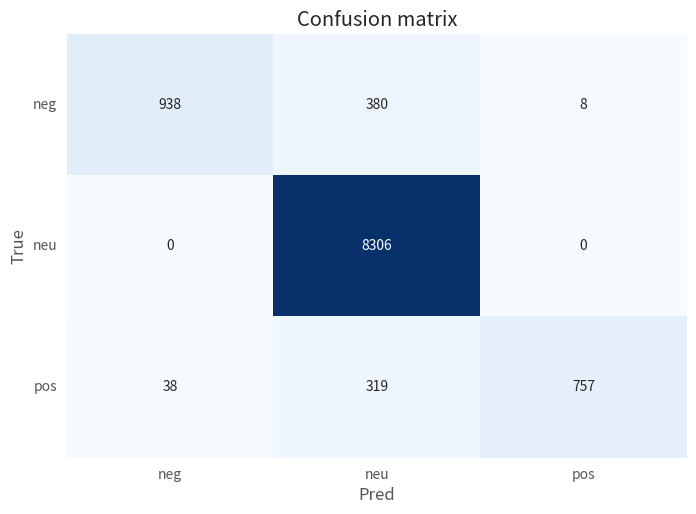

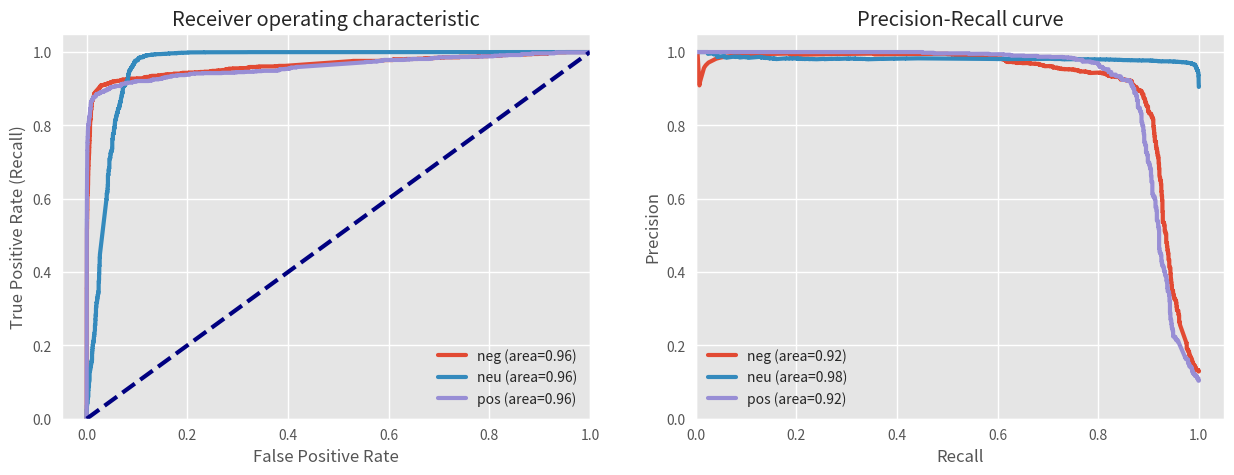

In [ ]:
model_type = "TF-IDF + logistic regression"
print(f"model type: {model_type}")

# 訓練模型
pred , pred_pro = model_predict(train_data, test_data, train_label,
                             vectorizer = vec_tfidf , classifier = cla_lg)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

### 5.2 Model Building : SVC

model type: CV + SVC
time costing: 429.4606924057007
Accuracy: 0.94
Auc: 0.96
Detail:
              precision    recall  f1-score   support

         neg       0.97      0.75      0.85      1326
         neu       0.93      1.00      0.96      8306
         pos       0.99      0.69      0.81      1114

    accuracy                           0.94     10746
   macro avg       0.96      0.81      0.87     10746
weighted avg       0.94      0.94      0.93     10746



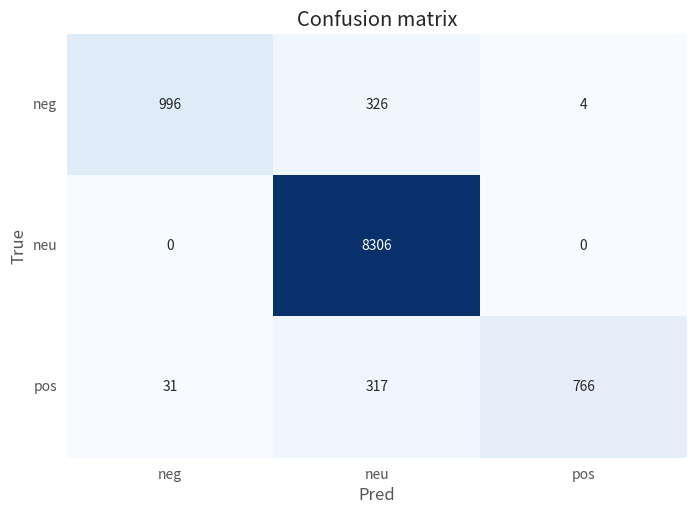

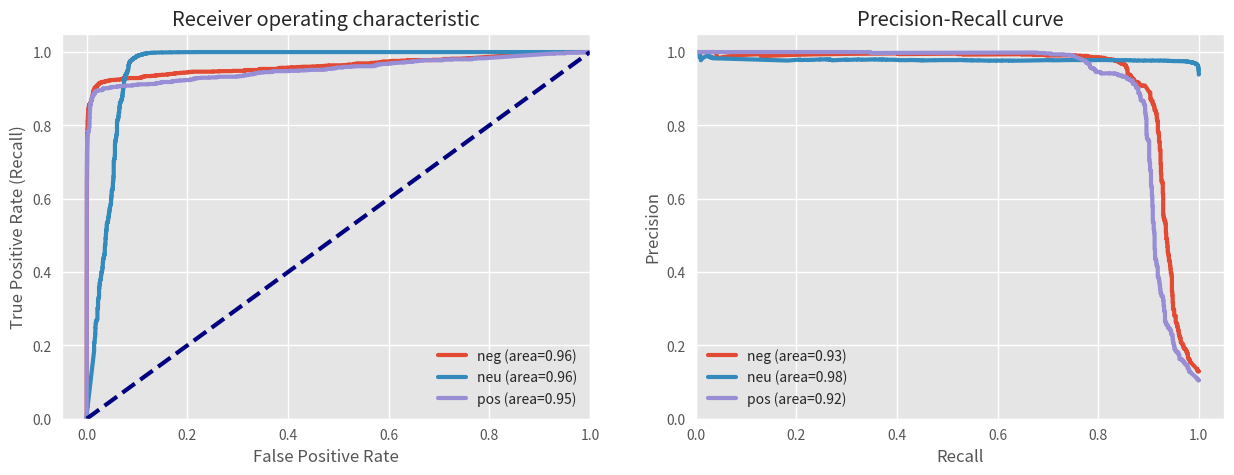

In [ ]:
model_type = "CV + SVC"
print(f"model type: {model_type}")
# 訓練模型
pred , pred_pro = model_predict(train_data, test_data, train_label,
                             vectorizer = vec_cv, classifier = cla_svc)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

model type: TF-IDF + SVC
time costing: 651.9853436946869
Accuracy: 0.94
Auc: 0.96
Detail:
              precision    recall  f1-score   support

         neg       0.97      0.76      0.85      1326
         neu       0.94      1.00      0.97      8306
         pos       0.99      0.74      0.84      1114

    accuracy                           0.94     10746
   macro avg       0.97      0.83      0.89     10746
weighted avg       0.95      0.94      0.94     10746



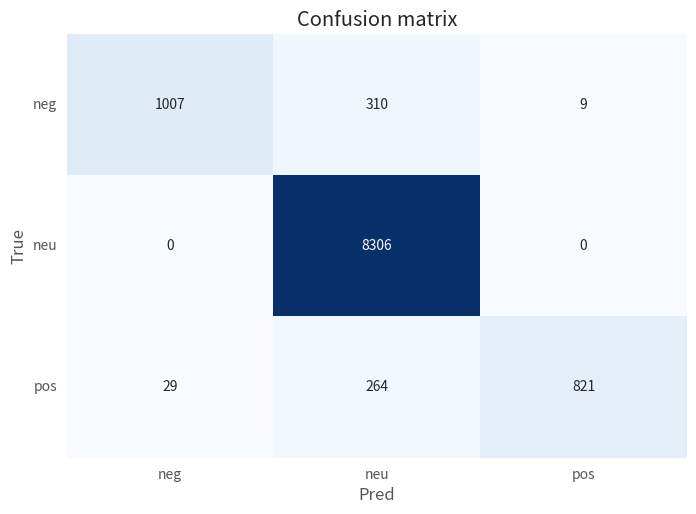

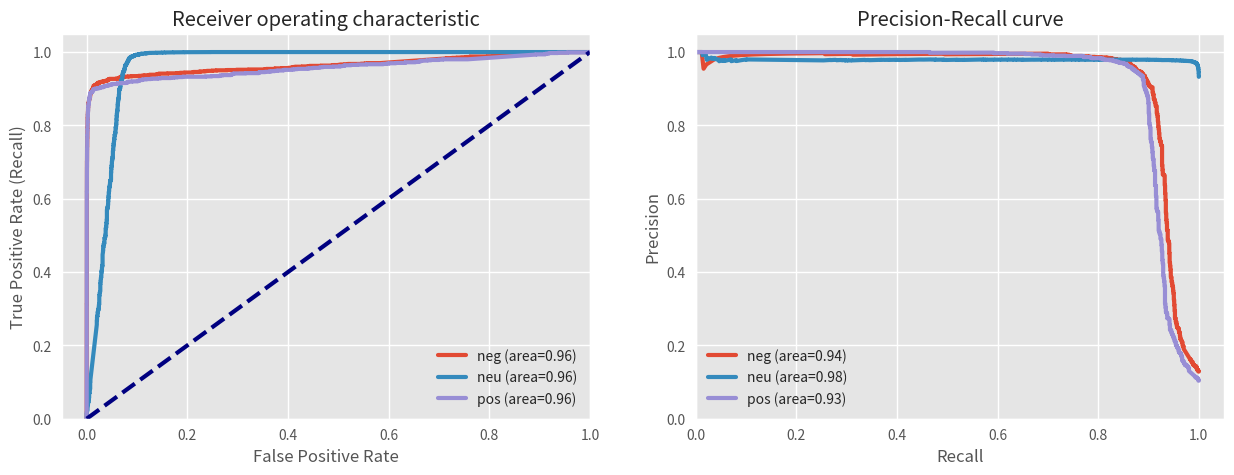

In [ ]:
model_type = "TF-IDF + SVC"
print(f"model type: {model_type}")
# 訓練模型
pred , pred_pro = model_predict(train_data, test_data, train_label,
                             vectorizer = vec_tfidf, classifier = cla_svc)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

### 5.3 Model Building : RandomForest

model type: CV + RandomForest
time costing: 30.231001615524292
Accuracy: 0.97
Auc: 0.96
Detail:
              precision    recall  f1-score   support

         neg       0.94      0.88      0.91      1326
         neu       0.97      1.00      0.98      8306
         pos       0.96      0.85      0.90      1114

    accuracy                           0.97     10746
   macro avg       0.96      0.91      0.93     10746
weighted avg       0.97      0.97      0.97     10746



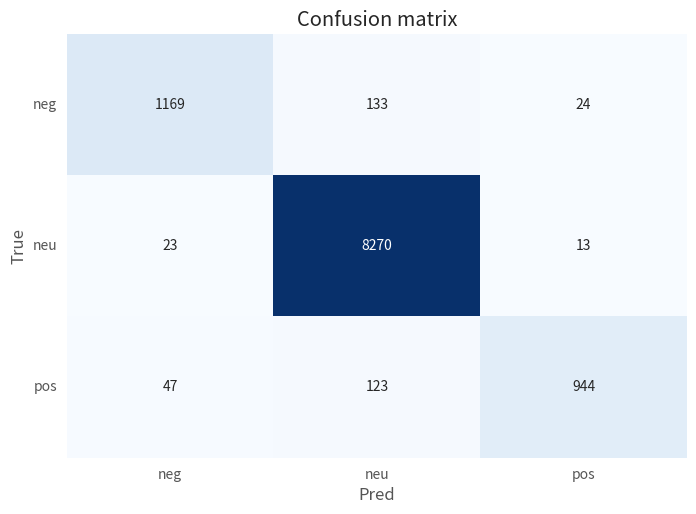

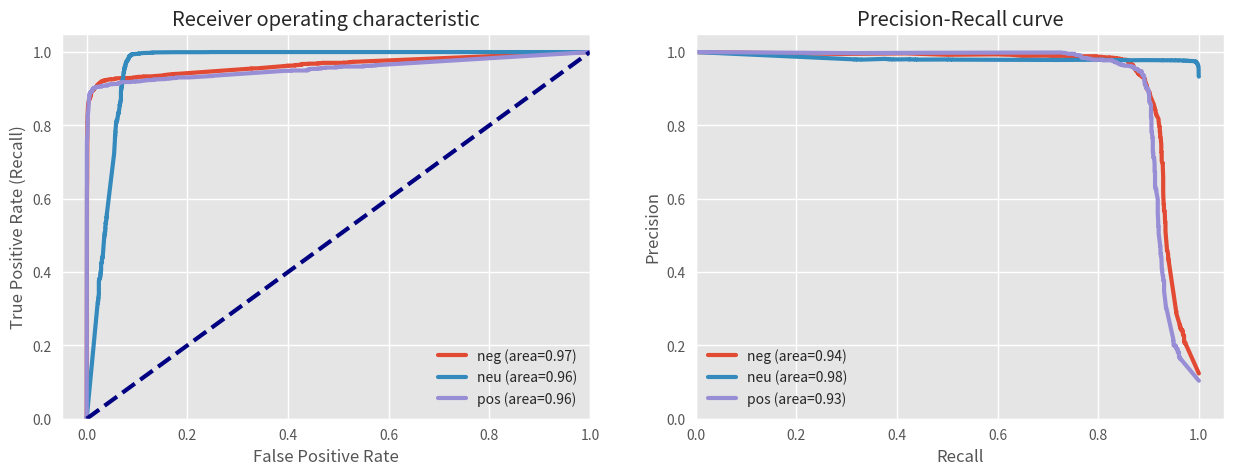

In [ ]:
model_type = "CV + RandomForest"
print(f"model type: {model_type}")
# 訓練模型
pred , pred_pro = model_predict(train_data, test_data, train_label,
                             vectorizer = vec_cv, classifier = cla_rf)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

model type: TF-IDF + RandomForest
time costing: 28.64065718650818
Accuracy: 0.97
Auc: 0.96
Detail:
              precision    recall  f1-score   support

         neg       0.95      0.88      0.91      1326
         neu       0.97      1.00      0.98      8306
         pos       0.96      0.85      0.90      1114

    accuracy                           0.97     10746
   macro avg       0.96      0.91      0.93     10746
weighted avg       0.97      0.97      0.97     10746



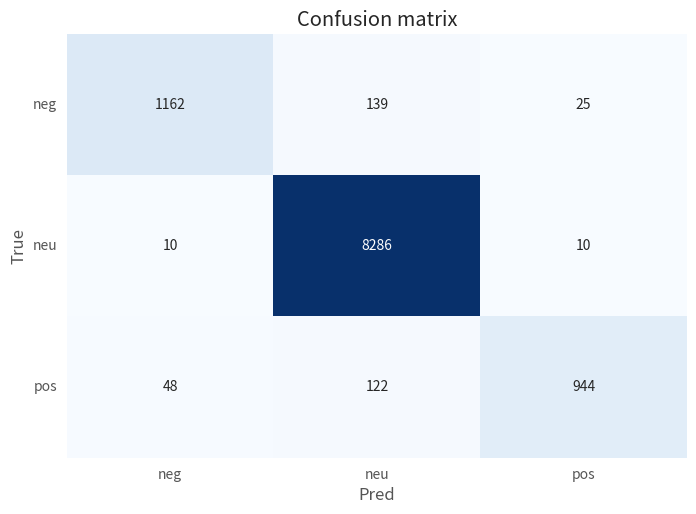

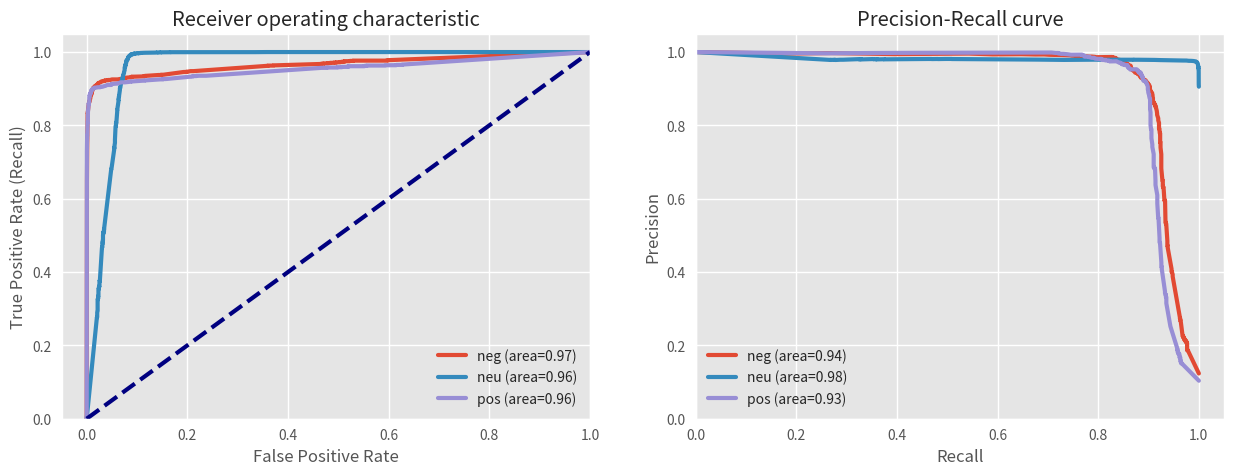

In [ ]:
model_type = "TF-IDF + RandomForest"
print(f"model type: {model_type}")
# 訓練模型
pred , pred_pro = model_predict(train_data ,test_data ,train_label,
                             vectorizer = vec_tfidf ,classifier = cla_rf)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

### 5.4 預測結果探索
+ 5.4.1 各字詞特徵的estimate係數
+ 5.4.2 查看分類錯誤的句子
+ 5.4.3 比較不同模型的ROC

查看模型預測結果

In [ ]:
result_df.sort_values(by=['Accuracy'], ascending=False)

,model_type,Accuracy,AUC
5,TF-IDF + RandomForest,0.967058,0.961932
4,CV + RandomForest,0.966220,0.961293
0,CV + logistic regression,0.953099,0.962125
3,TF-IDF + SVC,0.943049,0.961476
2,CV + SVC,0.936907,0.958958
1,TF-IDF + logistic regression,0.930672,0.962774


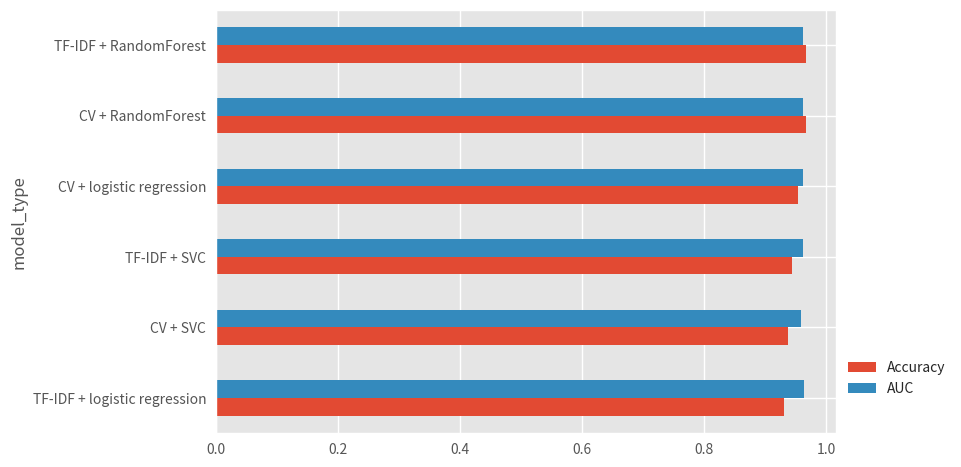

In [ ]:
result_df.sort_values(by=['Accuracy'], ascending=True) \
    .plot.barh(x="model_type", y=["Accuracy", "AUC"])
plt.legend(bbox_to_anchor=(1,0.2))

可以看到效果最好得組合是tf-idf，加上隨機森林的模型

#### 5.4.1 各字詞特徵的estimate係數
對於線性的模型，可以藉由相關係數，查看資料特徵（詞）對於判斷分類的影響
+ coefficient estimate代表特徵每增加一單位，y是1的發生機率比y是0的發生機率多幾倍（odds ratio 勝算比）
+ 這裡舉 5.1 的 logistic regression + cv tokenizer 為例

In [ ]:
def plot_coef(logreg_coef):    
    
    # 選出某個類別的前10大影響力字詞
    for label in logreg_coef.columns:
        top_n = 10
        select_words = logreg_coef[[label]].sort_values(by=label, ascending=False) \
                        .iloc[np.r_[0:top_n, -top_n:0]]    
        word = select_words.index
        count = select_words[label]        
        category_colors = np.where(select_words[label] >= 0, "darkseagreen","rosybrown") # 設定顏色
                
        fig, ax = plt.subplots(figsize =(8, 6)) # 設定畫布
        plt.rcParams['font.sans-serif'] = ['Source Han Sans TW']  # 設定中文
        plt.rcParams['axes.unicode_minus'] = False
        
        ax.barh(word, count, color=category_colors)
        ax.invert_yaxis()
        ax.set_title('Coeff increase/decrease odds ratio of 「'+ label +'」 label the most',
                     loc ='left', size = 16)
        ax.set_ylabel('word', size = 14)
        ax.set_xlabel('Word Frequency', size = 14)

In [ ]:
# 抓取 CountVectorizer 的字詞
vocabulary = vec_cv.get_feature_names()

# logisticRegr 是 5.1 存起來的模型
classes = logisticRegr.classes_ # 分類label
log_odds = logisticRegr.coef_.reshape(len(vocabulary),len(classes)) # 字詞係數
coef_df = pd.DataFrame(
                     log_odds, # value 字詞
                     vocabulary, # row 詞彙
                     columns = classes)  # column 是類別
coef_df.head(5)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,neg,neu,pos
00,0.345239,0.313821,-0.192322
04,0.120954,0.380340,-0.049314
10,-0.041194,-0.024036,0.009072
100,-0.039527,-0.201968,-0.017848
1000,-0.170065,-0.198786,0.076543


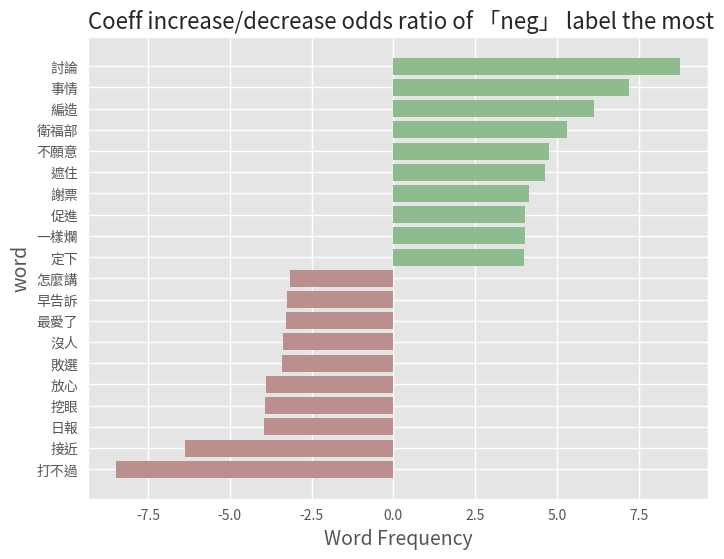

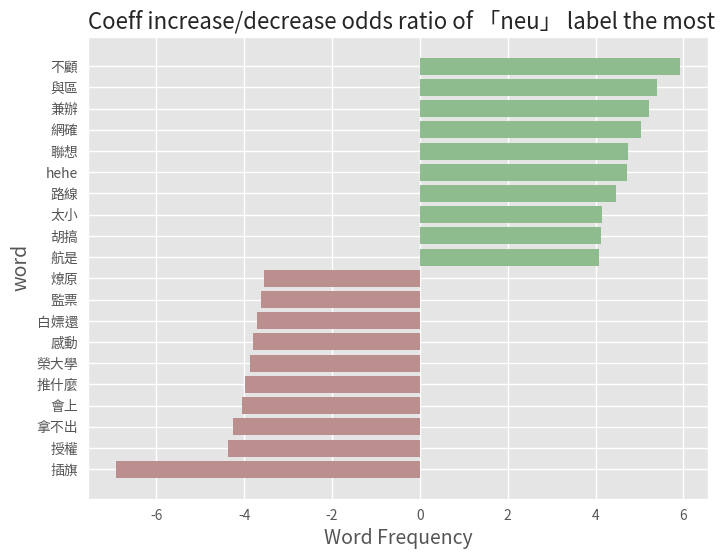

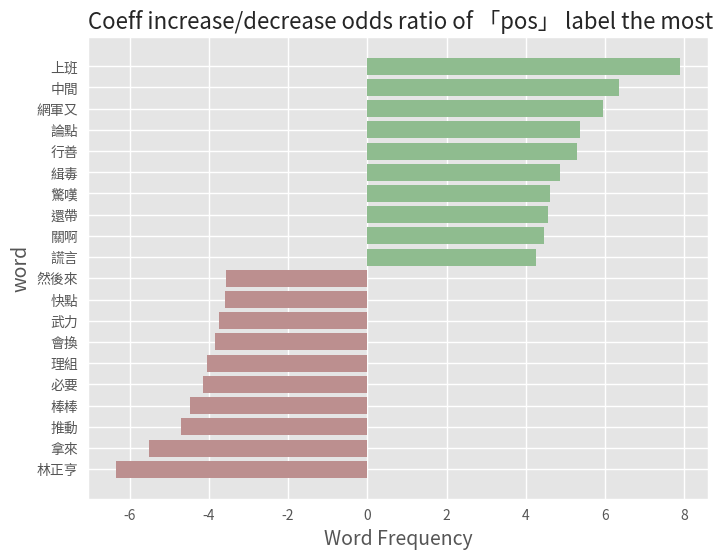

In [ ]:
# 把前10大影響力的字詞畫出來
plot_coef(coef_df)

#### 看一下含特定關鍵字的句子

In [ ]:
keyword_list = ['顏寬恒','顏清標','顏家'] 
data_senti[data_senti['sentence'].str.contains('|'.join(keyword_list),regex=True)][['document','sentence','artUrl','label']] \
                                .head(10)

,document,sentence,artUrl,label
0,0,Re:[新聞]快訊／陳柏惟罷免案「總投票率52.63%」其實當初陳柏惟擊落顏家板上是很振奮的...,https://www.ptt.cc/bbs/Gossiping/M.1634980712....,pos
1,1,[問卦]台中人484喜歡顏家啊?,https://www.ptt.cc/bbs/Gossiping/M.1634981115....,pos
2,2,看到台中人急著刪Q幫顏家出一口氣484顏家在台中貢獻頗大啊顏家到底貢獻了那些啊顏家正義跟善良...,https://www.ptt.cc/bbs/Gossiping/M.1634981115....,pos
4,4,市長有藍有綠說很穩的顏家也輸過也給過小黨機會老胡做了很久最後連任失敗黑龍連任失敗洪慈庸選上過...,https://www.ptt.cc/bbs/Gossiping/M.1634981688....,neg
6,6,我並不討厭陳柏惟只覺得他活該畢竟幹話講太多還是會被討厭況且重要的是他佔了顏家的地盤這樣會害人...,https://www.ptt.cc/bbs/Gossiping/M.1634982130....,neg
8,8,陳柏惟支持者謝謝台中人讓大家知道即便強如顏家也能被年輕的3Q打敗而只會訴諸台灣價值的3Q也不...,https://www.ptt.cc/bbs/Gossiping/M.1634982397....,neg
9,9,[問卦]這次罷免顏家反而該害怕吧？,https://www.ptt.cc/bbs/Gossiping/M.1634982501....,neg
10,10,這次罷免結果展現了票數的拉鋸以及選民對公共參與的熱烈反對同意票數其實沒有差很多所以在這個區塊...,https://www.ptt.cc/bbs/Gossiping/M.1634982501....,pos
12,12,陳柏惟支持者認真問一下3Q被罷掉後該不會就顏家的接棒吧我實在不想給黑道背景的接管耶個人沒政治...,https://www.ptt.cc/bbs/Gossiping/M.1634983670....,neg
13,13,[問卦]八卦版484上一代的縮影哈4我啦八卦版逐漸老人化這件事無庸置疑若是回到10年前肯定八...,https://www.ptt.cc/bbs/Gossiping/M.1634983721....,neg


#### 5.4.2 查看分類錯誤的句子

In [ ]:
# 把預測的值加回去
dtf_test['predict'] = pred
pos_wrong = dtf_test.loc[(dtf_test['label'] != dtf_test['predict']) & (dtf_test['label'] == 'pos')] # 正面句子分錯
neg_wrong = dtf_test.loc[(dtf_test['label'] != dtf_test['predict']) & (dtf_test['label'] == 'neg')] # 負面句子分錯
neu_wrong = dtf_test.loc[(dtf_test['label'] != dtf_test['predict']) & (dtf_test['label'] == 'neu')] # 中性句子分錯

print(f"pos label predicted wrong: {pos_wrong.shape[0]}")
print(f"neg label predicted wrong: {neg_wrong.shape[0]}")
print(f"neu label predicted wrong: {neu_wrong.shape[0]}")

pos label predicted wrong: 170
neg label predicted wrong: 164
neu label predicted wrong: 20


看一下都是什麼樣的句子分錯

In [ ]:
# 正面句子分錯
pos_wrong[['sentence','artUrl','label','predict']].head(5)

,sentence,artUrl,label,predict
811,位被罷免的嗎,https://www.ptt.cc/bbs/Gossiping/M.1634980712....,pos,neu
536,看到海線還是顏在稱霸蠻悲哀的,https://www.ptt.cc/bbs/Gossiping/M.1634980712....,pos,neg
33623,這也能洗4是對黨有多忠心,https://www.ptt.cc/bbs/Gossiping/M.1637823088....,pos,neu
31720,的太醜對比太突出惹w,https://www.ptt.cc/bbs/Gossiping/M.1637499889....,pos,neu
727,小丑被罷免剛好而已自作孽不可活,https://www.ptt.cc/bbs/Gossiping/M.1634980712....,pos,neu


In [ ]:
# 負面句子分錯
neg_wrong[['sentence','artUrl','label','predict']].head(5)

,sentence,artUrl,label,predict
9809,屬入境不用隔離14天嗎,https://www.ptt.cc/bbs/Gossiping/M.1635436822....,neg,neu
978,不然還有誰嘛,https://www.ptt.cc/bbs/Gossiping/M.1634981115....,neg,neu
586,扯顏能說明什麼,https://www.ptt.cc/bbs/Gossiping/M.1634980712....,neg,neu
714,在地服務是真的有做況且肇逃仔也沒,https://www.ptt.cc/bbs/Gossiping/M.1634980712....,neg,neu
858,不行喔就像南部仔愛西瓜啊,https://www.ptt.cc/bbs/Gossiping/M.1634981115....,neg,neu


In [ ]:
# 中性句子分錯
neu_wrong[['sentence','artUrl','label','predict']].head(5)

,sentence,artUrl,label,predict
5040,輸了就想改遊戲規則要不要臉啊,https://www.ptt.cc/bbs/Gossiping/M.1635001974....,neu,neg
30251,選賢與能可造福百姓的人,https://www.ptt.cc/bbs/Gossiping/M.1636951311....,neu,pos
19154,台中人智商哈哈,https://www.ptt.cc/bbs/Gossiping/M.1636443933....,neu,neg
9120,而且又是女性看民進党要不要打女拳,https://www.ptt.cc/bbs/Gossiping/M.1635334793....,neu,pos
17204,起沒毛病,https://www.ptt.cc/bbs/Gossiping/M.1636343494....,neu,pos


觀察模型分類效果，若一開始標註情況不佳，可以依據分類結果修改情緒字典

#### 5.4.3 比較不同模型的ROC

ROC 只適用二元分類，故將每個類別的預測都視作為一個二元分類，以下比較上面各模型的分類效果

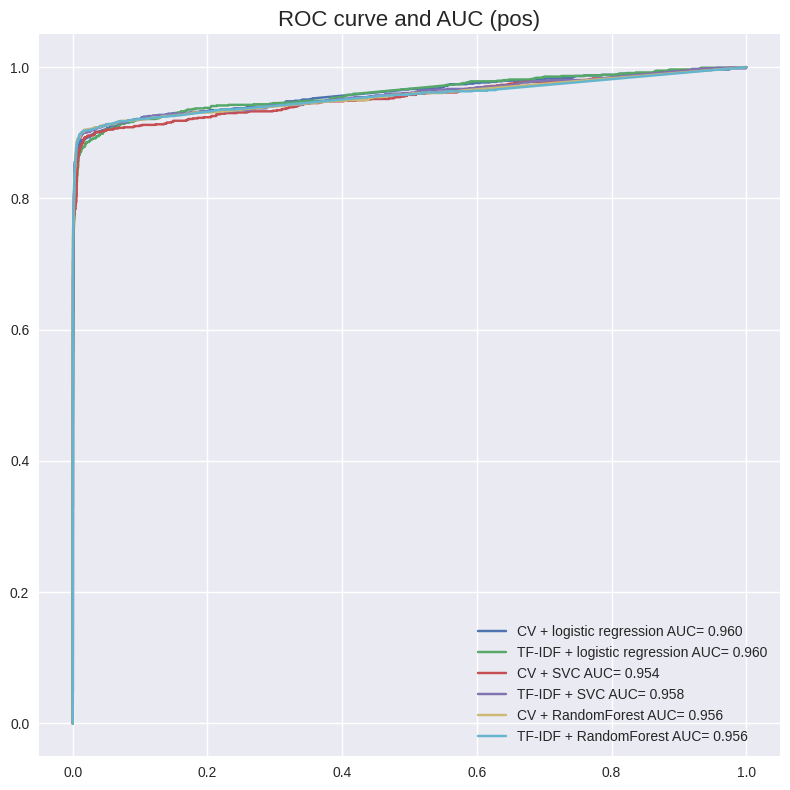

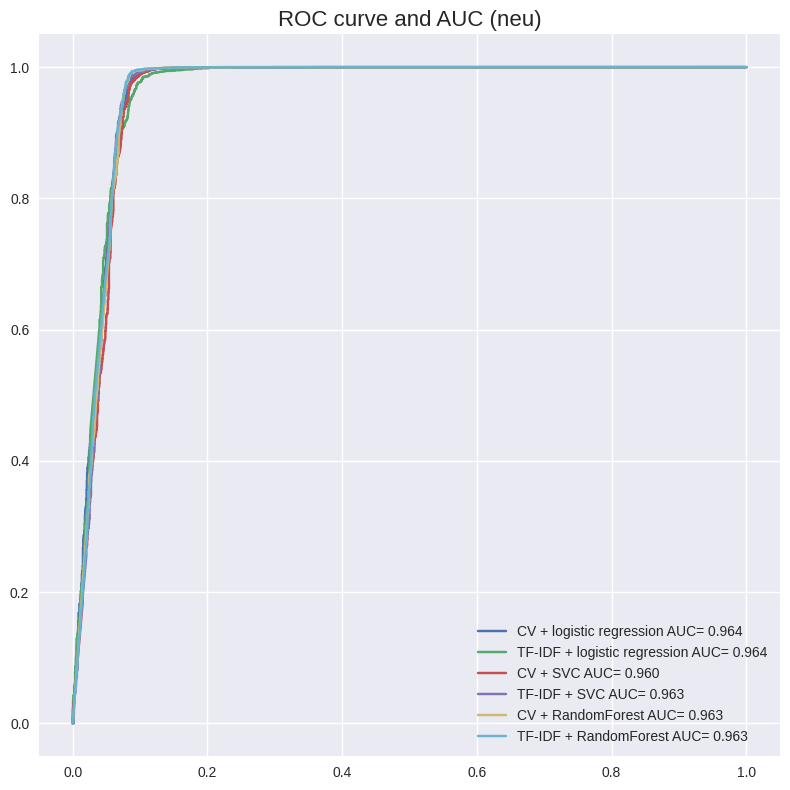

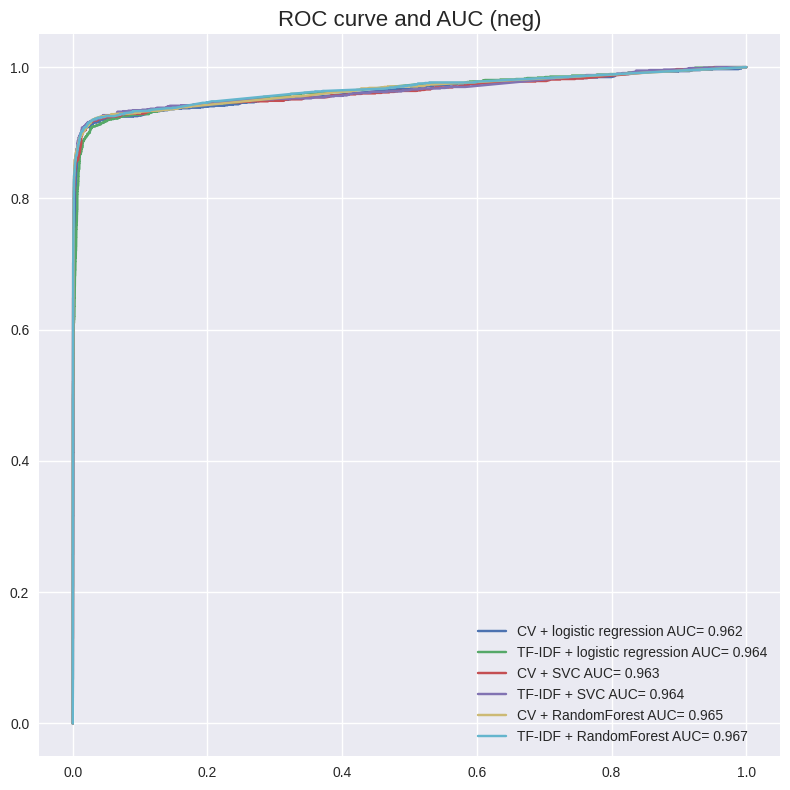

In [ ]:
plt.style.use('seaborn')    

l = ['pos','neu','neg']
for label in l:
    plt.figure(figsize =(8, 8))
    for k, v in roc_auc_all.items():
        fpr = roc_auc_all[k][label]["fpr"]
        tpr = roc_auc_all[k][label]["tpr"]
        roc_auc = roc_auc_all[k][label]["roc_auc"]
        plt.plot(fpr,tpr,label= k + " AUC= %0.3f" % roc_auc)
        plt.title('ROC curve and AUC ('+ label +')', size = 16)    
    plt.legend(loc=0)
    plt.tight_layout()

##結論



1.   各情緒的字詞分佈有甚麼不同，代表字詞有哪些?
    + 初步用詞頻探索發現，可以看到正面文章出現的詞有「罷免」、「顏家」、「支持」、「顏寬恒」等詞彙，負面文章則出現「八卦」、「黑道」、「垃圾」、「顏家」等詞彙。而「顏家」、「顏寬恒」、「民進黨」則因為是話題焦點，在兩邊的文章都頻繁出現。建模後觀察「編造」、「不願意」 等字是影響判斷為負面情緒的重要字；「行善」字是影響判斷為正面句子的重要字詞。
    
2.   此資料集用什麼樣的模型預測，準確率會較高？
    + 模型在三種情緒的AUC指標都不會相差太多，整體而TF-IDF+RandomForest和CV+RandomForest兩者表現差不多，都是本次使用的預測模型中最準確的，而其中最不準的則是TF-IDF+logistic regression。




